In [198]:
import sys, os, re
import importlib
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import find_peaks
from scipy.ndimage import uniform_filter1d, percentile_filter
from scipy.stats import binned_statistic, zscore
import scipy.stats as stats
import suite2p 
from suite2p.extraction import dcnv
import pandas as pd
import yaml, json
import copy
import glob 
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
import wesanderson
from cycler import cycler
import palettes
pio.renderers.default = "browser"

import neural_analysis_helpers
importlib.reload(neural_analysis_helpers)

from neural_analysis_helpers import get_psth, plot_avg_psth, split_psth, get_tuned_neurons, plot_avg_goal_psth, \
    get_landmark_psth, plot_avg_landmark_psth, plot_landmark_psth_map, plot_condition_psth_map, get_map_correlation, \
    get_tuned_neurons_shohei, get_rewards, get_rewarded_landmarks, get_landmark_category_entries, get_landmark_category_rew_idx, \
    get_landmark_categories, load_vr_behaviour_data, load_nidaq_behaviour_data, get_lm_entry_exit, load_vr_session_info, get_position_info, \
    get_landmark_id_psth

import parse_session_functions
importlib.reload(parse_session_functions)

from parse_session_functions import load_session, load_config, create_session_struct, get_lap_idx, get_lm_idx, calc_laps_needed, get_active_goal, get_rewarded_lms, get_lms_visited

tm_palette = palettes.met_brew('Tam',n=123, brew_type="continuous")
tm_palette = tm_palette[::-1]
color_scheme = wesanderson.film_palette('Darjeeling Limited',palette=0)
custom_cycler = cycler(color=color_scheme)
hfs_palette = np.array(palettes.met_brew('Austria',n=8, brew_type="continuous"))

<BarContainer object of 16 artists>

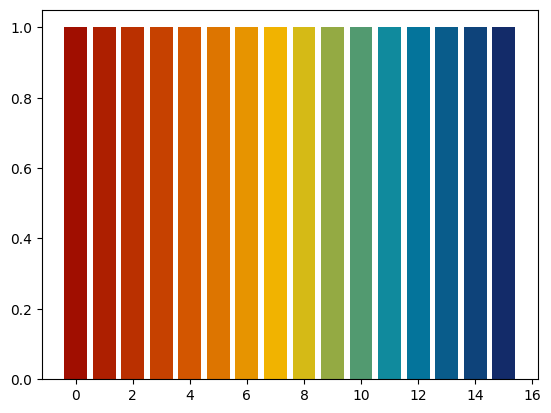

In [10]:
# Palette testing
cont_palette = palettes.met_brew('Johnson',n=16, brew_type="continuous")
fig,ax = plt.subplots(1,1)
ax.bar(range(16), np.ones(16), capsize=3, color=cont_palette[:16])

# Discrete: Archambault, Austria, Cross, Johnson
# Continuous: VanGogh1, Pillement


#### Load data

In [199]:
# Define relevant directories and session specific info
basepath = '/Volumes/mrsic_flogel/public/projects/AtApSuKuSaRe_20250129_HFScohort2'
animal = 'TAA0000066'
session = 'ses-010_date-20250314_protocol-t4'
# session = 'ses-011_date-20250315_protocol-t5'
# session = 'ses-012_date-20250318_protocol-t6'
# session  = 'ses-018_date-20250403_protocol-t12'
sess_data_path = basepath + '/' + animal + '/' + session
func_img_path = 'funcimg/Session'
save_path = sess_data_path + '/analysis'
if not os.path.exists(save_path):
    os.makedirs(save_path)

protocol_num = int(re.search(r'protocol-t(\d+)', session).group(1))
print(f'Working on T{protocol_num}')

if animal == 'TAA0000066' or animal == 'TAA0000059':
    if protocol_num == 3 or protocol_num == 4:
        sequence = 'AB_shuffled'
    elif protocol_num == 5 or protocol_num == 6:
        sequence = 'ABAB'
    else:
        print('This code does not work before T3 or beyond T6 yet.')
elif animal == 'TAA0000061' or animal == 'TAA0000064':
    if protocol_num == 3 or protocol_num == 4:
        sequence = 'AABB'
    elif protocol_num == 5 or protocol_num == 6:
        sequence = 'ABAB'
    else:
        print('This code does not work before T3 or beyond T6 yet.')
elif animal == 'TAA0000062' or animal == 'TAA0000065':
    if protocol_num == 3 or protocol_num == 4:
        sequence = 'AB_shuffled'
    elif protocol_num == 5 or protocol_num == 6:
        sequence = 'AABB'
    else:
        print('This code does not work before T3 or beyond T6 yet.')
else:
    raise ValueError("Oops I don't know what to do about this mouse")

# Recording params
nidaq_sampling_rate = 9000
vdaq_sampling_rate = 5000
funcimg_frame_rate = 45  # frames/s
if protocol_num <= 5:
    funcimg_recording_duration = 30 # min 
elif protocol_num >= 6:
    funcimg_recording_duration = 45 # min 
else:
    print('Please specify the funcimg recording duration!')
    
save_npz = True
save_csv = True

Working on T4


In [1]:
# Load data 

# Load nidaq data 
data = load_nidaq_behaviour_data(sess_data_path)
# print(data.files)

# Load behaviour relevant frames 
valid_frames = np.load(os.path.join(sess_data_path, 'valid_frames.npz'))['valid_frames']

# Load VR data 
position_data, options = load_vr_behaviour_data(sess_data_path)
session = create_session_struct(position_data, options)
session = get_lap_idx(session)
session = get_lm_idx(session)
session = get_rewarded_lms(session)
session = get_active_goal(session)
session = calc_laps_needed(session)
session = get_lms_visited(options, session)

print('Number of laps = ', session['num_laps'])
num_lms = len(session['all_landmarks'])
print('Number of landmarks visited = ', num_lms)

rulename = options['sequence_task']['rulename']
if rulename == 'run-auto' or rulename == 'run-lick':  # stages 1-2
    start_odour = False  # VR started with reward delivery
elif rulename == 'olfactory_shaping' or rulename == 'olfactory_test':  # stages 3-6
    start_odour = True  # first VR event was the odour delivery prep

    if rulename == 'olfactory_test':
        num_landmarks = 10
    else:
        num_landmarks = 2
        # print('Please specify the number of landmarks in the corridor!')  # TODO: read this from config file

# Load suite2p outputs
ops = np.load(os.path.join(sess_data_path, func_img_path, 'suite2p/plane0/ops.npy'), allow_pickle=True).item()
iscell = np.load(os.path.join(sess_data_path, func_img_path, 'suite2p/plane0/iscell.npy'))[:,0]

neurons = np.where(iscell == 1)[0]  # select ROIs that are classified as neurons
num_neurons = len(neurons)


NameError: name 'load_nidaq_behaviour_data' is not defined

In [ ]:
# Get landmark information 

# 1. Find data idx closest to landmark entry and exit
lm_entry_idx, lm_exit_idx = get_lm_entry_exit(session, positions=data['position'])

# 2. Define which landmarks belong to goals, non-goals and test
session = get_landmark_categories(sequence, num_landmarks, session)

# 3. Find licks
lick_idx = np.where(data['licks'] == 1)[0]

# 4. Find landmarks that were rewarded
rewarded_landmarks = get_rewarded_landmarks(position_data, data, session)

# 5. Find landmark entries by catetory 
rew_lm_entry_idx, miss_lm_entry_idx, nongoal_lm_entry_idx, test_lm_entry_idx = \
    get_landmark_category_entries(position_data, data, sequence, num_landmarks, session)

# 6. Find indices of rewards or 'imaginary' rewards in rewarded and non-rewarded landmarks
session = get_landmark_category_rew_idx(sequence, num_landmarks, session, position_data, data)

# all_reward_idx = np.sort(np.concatenate([reward_idx, miss_rew_idx, nongoal_rew_idx, test_rew_idx]))

Total rewards considered here:  125
Total rewards not considered here:  0
Total assistant and manual rewards:  0
Reward time lag from lm entry:  17.0


#### Compute DF/F

In [202]:
# Load F and Fneu
calculate_DF_F = False

DF_F_file = os.path.join(sess_data_path, func_img_path, 'suite2p/plane0/DF_F0.npy')

if os.path.exists(DF_F_file) and calculate_DF_F is False:
    print('DF_F0 file found. Loading...')
    
    DF_F_all = np.load(DF_F_file)
    DF_F = DF_F_all[:, valid_frames]
    print(DF_F.shape)
    
else:
    calculate_DF_F = True
    F = np.load(os.path.join(sess_data_path, func_img_path, 'suite2p/plane0/F.npy'))
    Fneu = np.load(os.path.join(sess_data_path, func_img_path, 'suite2p/plane0/Fneu.npy'))

DF_F0 file found. Loading...
(550, 79300)


In [203]:
# Option 1 - Sandra: using moving percentile for F0 (https://www.nature.com/articles/s41586-021-03452-z#Sec7)
# F0 is defined as the 25th percentile of the fluorescence trace in a sliding window of 60 s
# The average green fluorescence signal was extracted for each cell and then corrected for neuropil contamination 
# by subtracting the signal of 30 μm surrounding each cell multiplied by 0.7 and adding the median multiplied by 0.7

# Fcorr = F - 0.7 * Fneu + 0.7 * np.median(Fneu, axis=1).reshape(-1,1)

# F0 = np.zeros(np.shape(F))
# f0_window = 60 * funcimg_frame_rate  # frames
# for n in neurons:  # Loop over neurons (rows)
#     F0[n, :] = percentile_filter(F[n, :], percentile=25, size=f0_window, mode='nearest')

# DF_F_all = (Fcorr - F0) / F0  # Compute DF/F as (F-F0)/F0 per frame per neuron

# # Select the correct frames that fall within VR behaviour 
# DF_F = DF_F_all[:, valid_frames]

# for n in neurons[0:10]:
#     plt.figure()
#     plt.plot(F[n,0:2000], label='F')
#     plt.plot(Fcorr[n,0:2000], label='Fcorr')
#     plt.plot(F0[n,0:2000], label='F0')
#     plt.plot(DF_F[n,0:2000], label='DF/F0')
#     plt.legend()

In [204]:
# Option 2 - suite2p: and dividing by mean F0 (https://github.com/MouseLand/suite2p/issues/598)
# For computing and subtracting baseline:
# baseline = 'maximin' # take the running max of the running min after smoothing with gaussian
# sig_baseline: in bins, standard deviation of gaussian with which to smooth
# win_baseline: in seconds, window in which to compute max/min filters
if calculate_DF_F:
    prctile_baseline = 25

    F0 = 0.7 * Fneu
    mean_F0 = np.mean(F0, axis=1)

    DF = F.copy() - F0
    DF = dcnv.preprocess(DF, ops['baseline'], ops['win_baseline'], ops['sig_baseline'], ops['fs'], prctile_baseline)

    DF_F_all = DF / mean_F0.reshape(-1, 1)  # normalize by mean F0  (https://suite2p.readthedocs.io/en/latest/FAQ.html)

    # Select the correct frames that fall within VR behaviour 
    DF_F = DF_F_all[:, valid_frames]
    print(DF_F.shape)

    for n in neurons[0:10]:
        plt.figure()
        plt.plot(F[n,0:2000], label='F')
        plt.plot(F0[n,0:2000], label='F0')
        plt.plot(DF_F[n,0:2000], label='DF/F0')
        plt.legend()

    # Save data 
    np.save(DF_F_file, DF_F_all)

In [205]:
# Option 3 - suite2p: but adding arbitrary value to F0 computed by suite2p to avoid division by zero.

# prctile_baseline = 25

# F0 = 0.7 * (Fneu + 15)  # add arbitrary value to F0 computed by suite2p 

# DF = F.copy() - F0
# DF = dcnv.preprocess(DF, ops['baseline'], ops['win_baseline'], ops['sig_baseline'], ops['fs'], prctile_baseline)

# DF_F_all = DF / F0

# # Select the correct frames that fall within VR behaviour 
# DF_F = DF_F_all[:, valid_frames]
# print(DF_F.shape)

# for n in neurons[0:10]:
#     plt.figure()
#     plt.plot(F[n,0:2000], label='F')
#     plt.plot(F0[n,0:2000], label='F0')
#     plt.plot(DF_F[n,0:2000], label='DF/F0')
#     plt.legend()

In [206]:
# Option 4 - Shohei: Gaussian mixture model on F (https://www.nature.com/articles/s41586-024-07851-w#Sec6)
# Calcium ΔF/F0 signals were obtained by using the baseline fluorescence F0, which is estimated by a 
# Gaussian mixture model with two components fitted on the raw fluorescence data. The mean parameter of 
# the lowest Gaussian component is used as F0. 
# from sklearn.mixture import GaussianMixture

# def estimate_f0_gmm(trace):
#     # Fit GMM with 2 components
#     gmm = GaussianMixture(n_components=2, random_state=0)
#     gmm.fit(trace.reshape(-1, 1))

#     # Get the means of the components
#     means = gmm.means_.flatten()
        
#     # Select the mean of the component with the lowest mean value
#     f0 = np.min(means)

#     return f0

# F0 = np.array([estimate_f0_gmm(trace) for trace in F])
# print(F0.shape)

# DF_F_all = (F - F0[:, np.newaxis]) / F0[:, np.newaxis]

# # Select the correct frames that fall within VR behaviour 
# DF_F = DF_F_all[:, valid_frames]
# print(DF_F.shape)

# for n in neurons[0:10]:
#     plt.figure()
#     plt.plot(F[n, :2000], label='F')
#     plt.axhline(F0[n], color='gray', linestyle='--', label='F0')
#     plt.plot(DF_F_all[n, :2000], label='ΔF/F₀')
#     plt.legend()


Out of the 550 ROIs, 268 are classified as neurons, and 188 have time-varying Ca2+ signals and will be considered here.


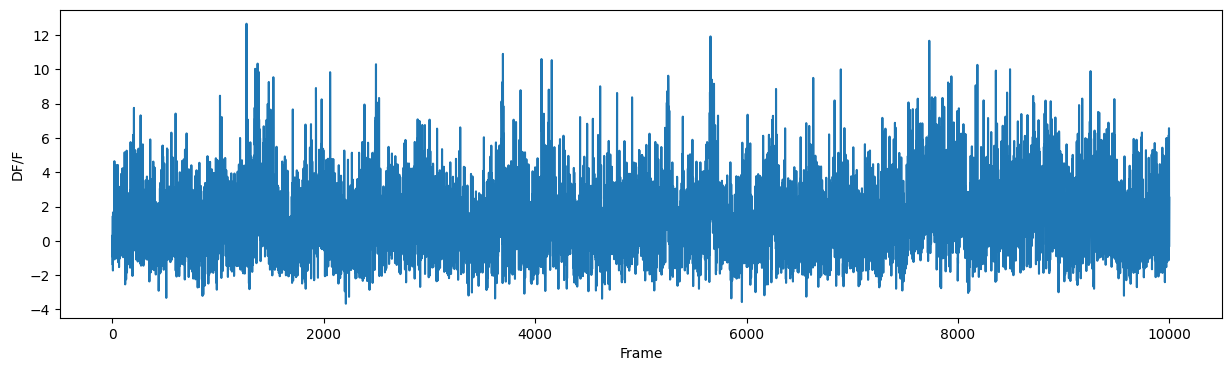

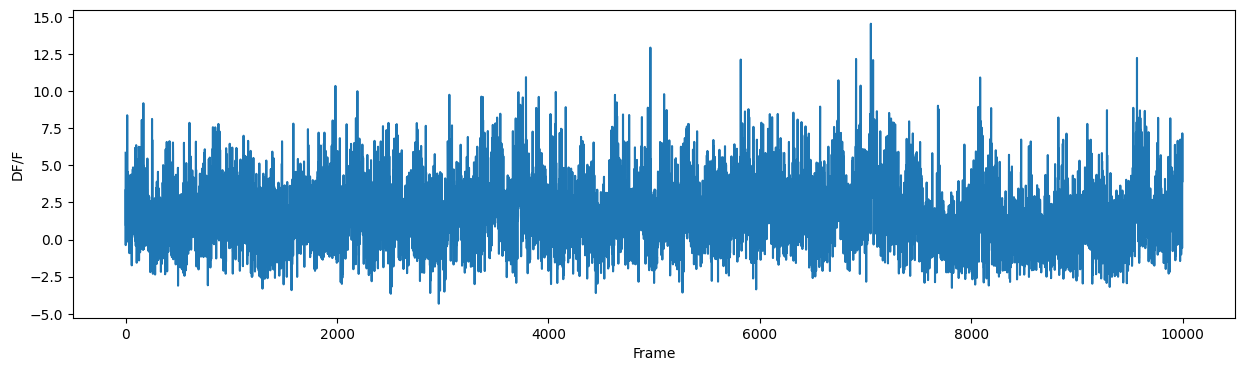

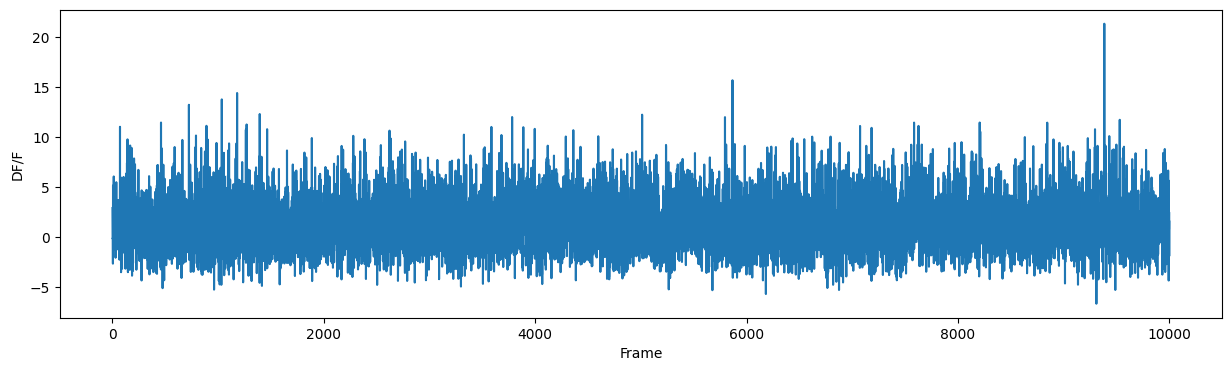

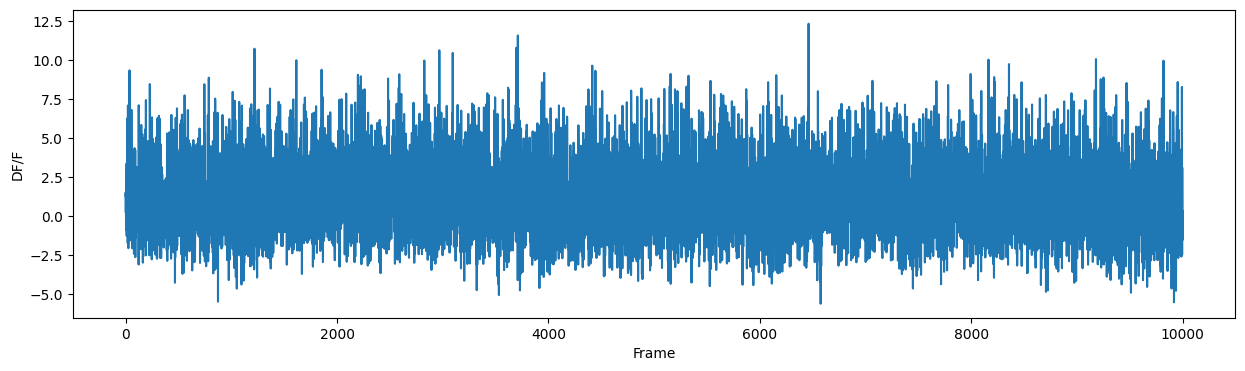

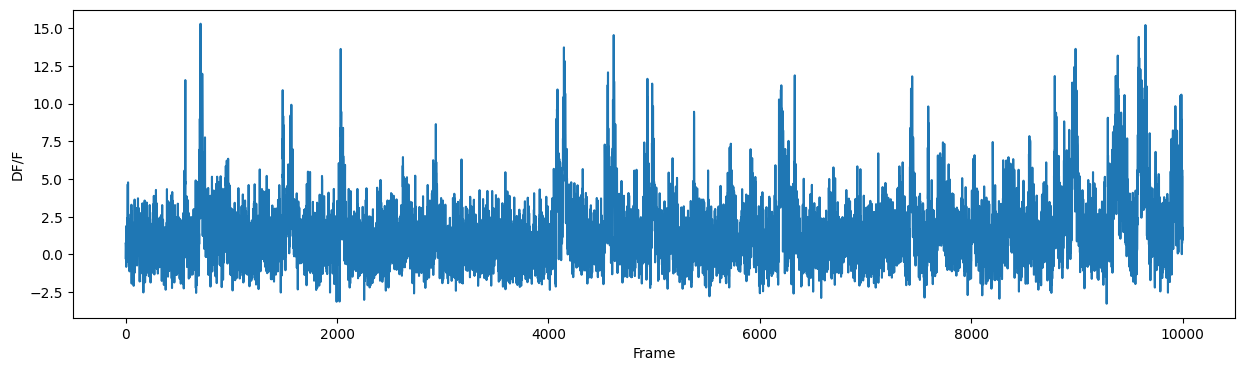

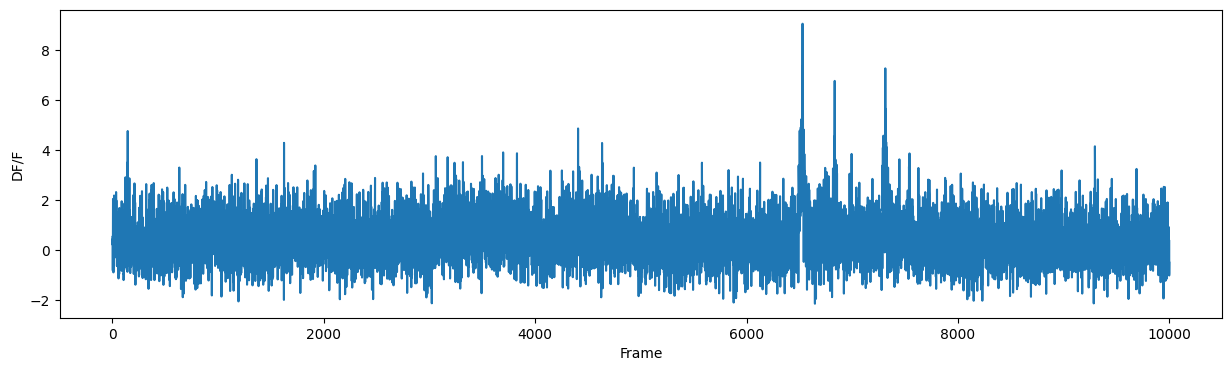

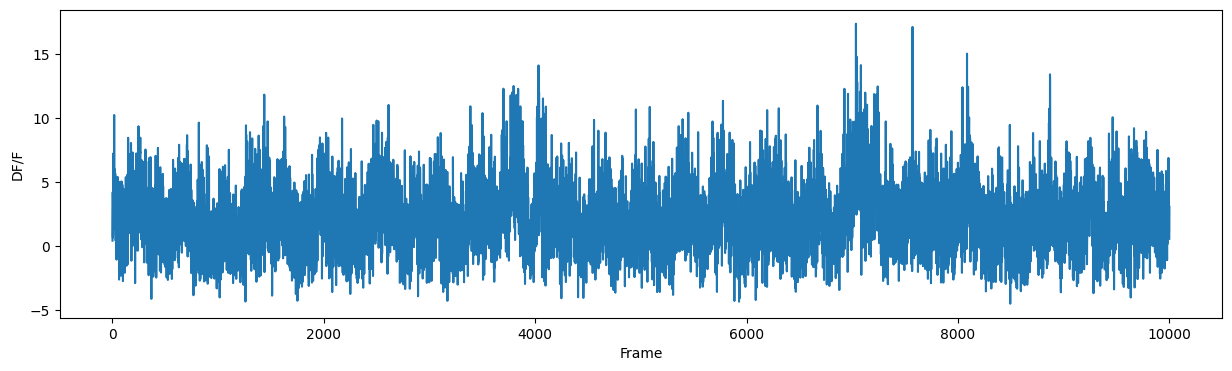

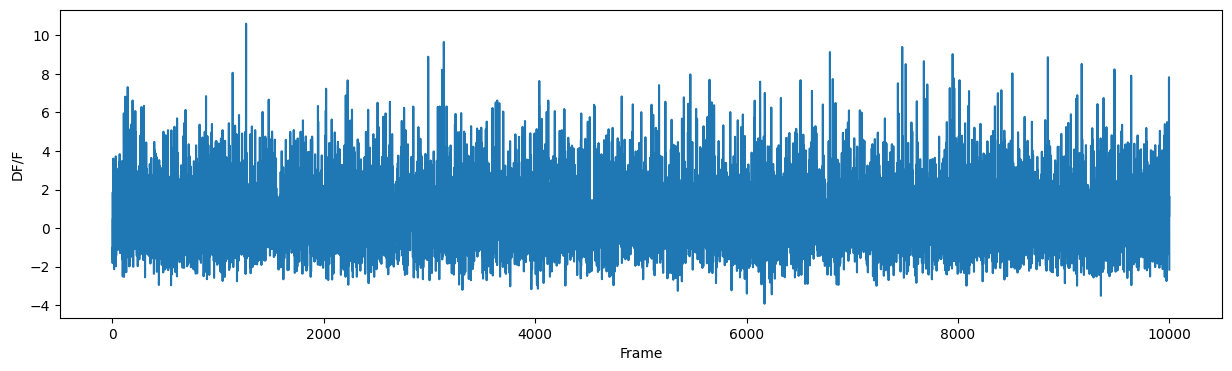

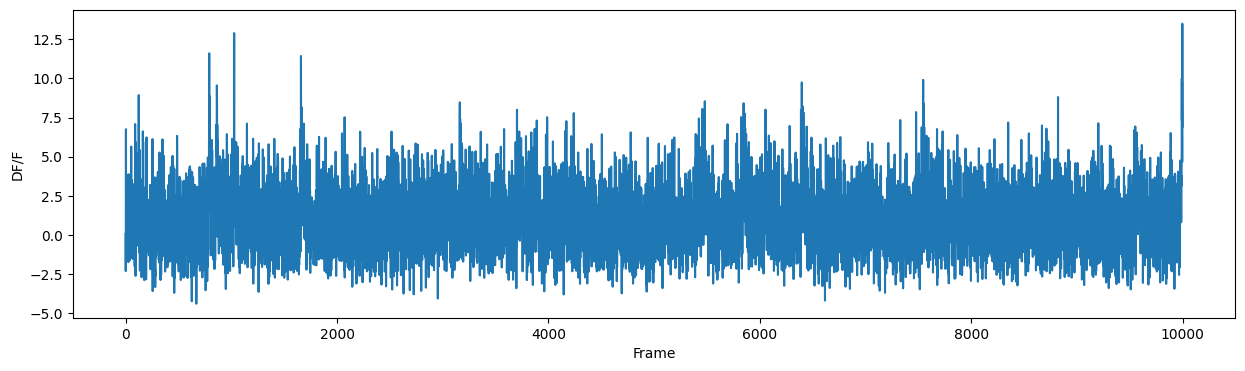

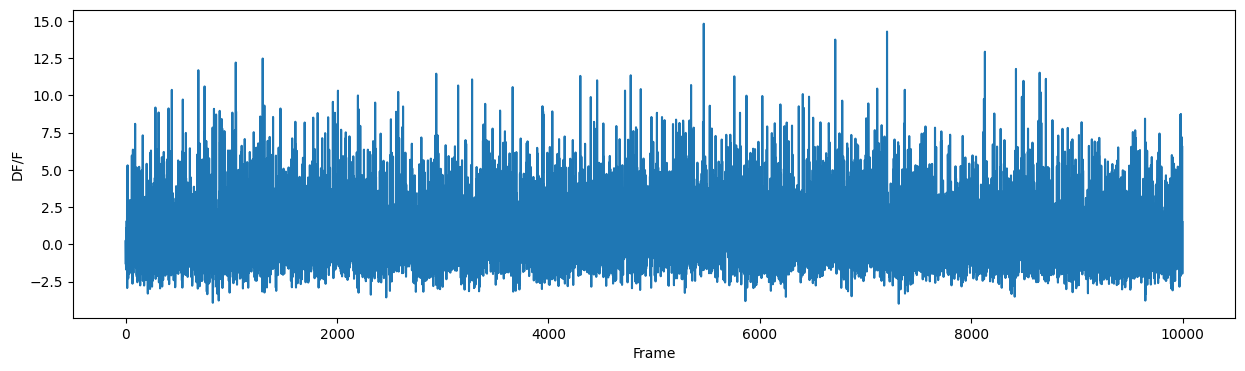

In [207]:
# Look at distribution of DF/F to select neurons
neurons_considered = []
for n in neurons: 
    deltas = DF_F[n,:] - np.mean(DF_F[n,:])
    # plt.hist(deltas, bins=100)
    skew = stats.skew(deltas)

    if skew > 0.5:
        neurons_considered.append(n)

num_neurons_considered = len(neurons_considered)
print(f'Out of the {DF_F.shape[0]} ROIs, {num_neurons} are classified as neurons, and {num_neurons_considered} have time-varying Ca2+ signals and will be considered here.')

neurons_considered = np.array(neurons_considered)
np.savez(os.path.join(save_path, f'T{protocol_num}_neurons_considered.npz'), neurons_considered)

# Plot a few neurons
plot_range = 10000
xdata = np.arange(0, plot_range) 
for n in neurons_considered[0:10]:
    fig, ax = plt.subplots(1, 1, figsize=(15,4), sharey=True)
    ax.plot(xdata, DF_F[n,0:plot_range])
    ax.set_xlabel('Frame')
    ax.set_ylabel('DF/F')

In [208]:
# Compare with deconvoluted spikes
# plot_range = 10000
# xdata = np.arange(0, plot_range) 

# for n in neurons_considered[0:10]:
#     fig, ax = plt.subplots(1, 1, figsize=(15,4), sharey=True)
#     ax.plot(xdata, DF_F[n,0:plot_range], label='DF/F0')
#     ax.plot(xdata, data['Ca_traces'][n,0:plot_range], alpha=0.5, label='spikes')
#     ax.set_xlabel('Frame')
#     ax.set_ylabel('DF/F')
#     ax.legend()

#### Reward PSTH 

In [ ]:
# Initialize saving variables
time_around = 0.5
save_filename = os.path.join(save_path, f'T{protocol_num}_rewards_analysis_{time_around}s.npz')
reload_results = False

if os.path.exists(save_filename) and not reload_results:
    print('Reward anlaysis has already been performed. Loading...')
    results_rewards = np.load(save_filename, allow_pickle=True)
else: 
    reload_results = True
    results_rewards = {}

85 neurons are tuned to reward.


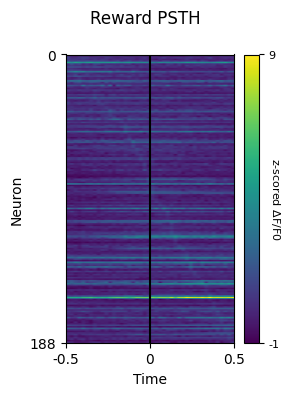

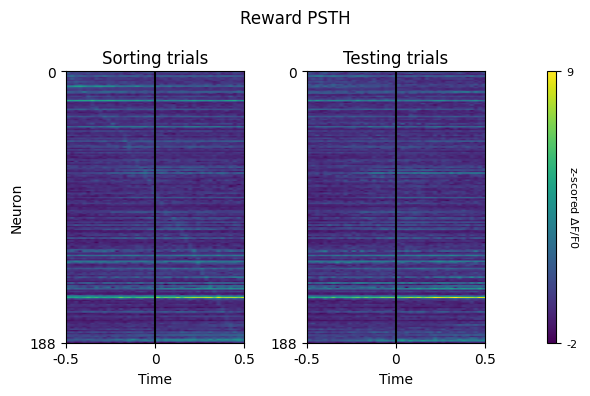

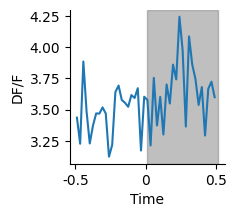

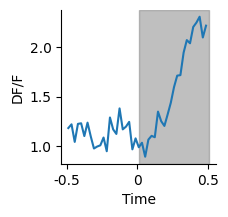

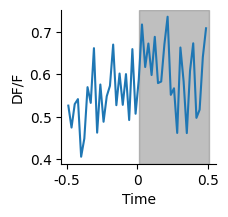

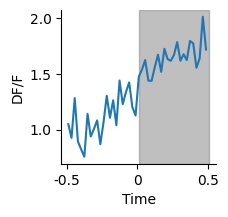

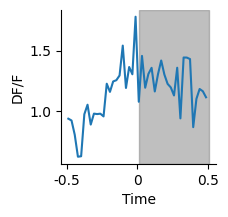

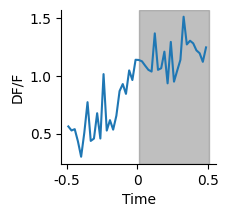

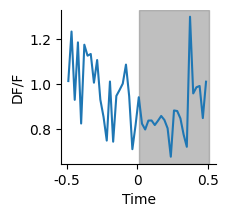

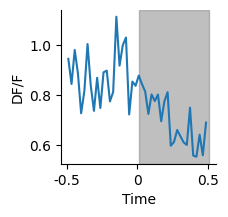

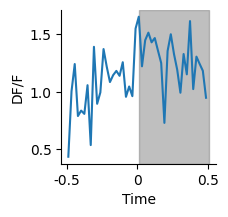

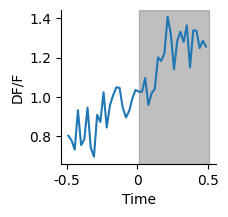

In [ ]:
# Get reward PSTH
if reload_results:
    reward_psth, average_reward_psth = get_psth(data=DF_F, neurons=neurons_considered, event_idx=session['reward_idx'], \
                                                            time_around=time_around)

    plot_avg_psth(average_psth=average_reward_psth, event='Reward', zscoring=True, time_around=time_around)

    split_psth(psth=reward_psth, event_idx=session['reward_idx'], event='Reward', zscoring=True, time_around=time_around)

    # Get reward-tuned neurons
    significant_neurons_reward = get_tuned_neurons(average_reward_psth, event='reward', time_around=time_around, plot_neurons=True)

    results_rewards['reward_psth'] = reward_psth
    results_rewards['average_reward_psth'] = average_reward_psth
    results_rewards['significant_neurons_reward'] = significant_neurons_reward

##### Reward-specific tuning

In [ ]:
if reload_results:

    if protocol_num > 5:
        ABCD_goals = [1,2,3,4]
        ABCD_rewards_idx = {}
        reward_id_psth = {}
        average_reward_id_psth = {}
        significant_neurons_reward_id = {}

        for goal in ABCD_goals:

            # Find rewards by goal ID
            ABCD_rewards_idx[goal] = np.array([session['reward_idx'][i] for i, idx in enumerate(rewarded_landmarks) \
                                            if session['all_lms'][idx] == goal])

            # Get reward PSTH by goal ID 
            reward_id_psth[goal], average_reward_id_psth[goal] = get_psth(data=DF_F, neurons=neurons_considered, \
                                                                        event_idx=ABCD_rewards_idx[goal], time_around=time_around)
            
            # Find neurons tuned to each reward by goal ID
            significant_neurons_reward_id[goal] = get_tuned_neurons(average_reward_id_psth[goal], \
                                                                event=f'reward {goal}', time_around=time_around, plot_neurons=False)
            
        # Find neurons tuned to any reward
        all_significant_neurons_reward = np.unique(np.concatenate([significant_neurons_reward_id[goal] for goal in ABCD_goals]))
        print(f'{len(all_significant_neurons_reward)} neurons are tuned to any reward.')

        results_rewards['reward_id_psth'] = reward_id_psth
        results_rewards['average_reward_id_psth'] = average_reward_id_psth
        results_rewards['significant_neurons_reward_id'] = significant_neurons_reward_id
        results_rewards['all_significant_neurons_reward'] = all_significant_neurons_reward

    else:
        all_significant_neurons_reward = significant_neurons_reward
        results_rewards['all_significant_neurons_reward'] = all_significant_neurons_reward
        print('This does not make sense before T5.')
    

This does not make sense before T5.


In [176]:
# Tuning using Shohei's method (https://www.nature.com/articles/s41586-024-07851-w#Sec6)
# ABCD_goals = [1,2,3,4]
# ABCD_rewards_idx = {}
# reward_id_psth = {}
# average_reward_id_psth = {}
# significant_neurons_reward_id = {}

# for goal in ABCD_goals:

#     # Find rewards by goal ID
#     ABCD_rewards_idx[goal] = np.array([reward_idx[i] for i, idx in enumerate(rewarded_landmarks) \
#                                        if all_goals[idx] == goal])

#     # Get reward PSTH by goal ID 
#     reward_id_psth[goal], average_reward_id_psth[goal] = get_psth(data=DF_F, neurons=neurons_considered, \
#                                                                  event_idx=ABCD_rewards_idx[goal], time_around=1)
    
#     # Find neurons tuned to each reward by goal ID
#     significant_neurons_reward_id[goal] = get_tuned_neurons_shohei(DF_F=DF_F, average_psth=average_reward_id_psth[goal], neurons=neurons_considered, \
#                                                          event=f'reward {goal}', time_around=1, plot_neurons=True, zscoring=True)
    
# # Find neurons tuned to any reward
# all_significant_neurons_reward = np.unique(np.concatenate([significant_neurons_reward_id[goal] for goal in ABCD_goals]))
# print(f'{len(all_significant_neurons_reward)} neurons are tuned to any reward.')



##### Compare average reward PSTH map in rewarded vs non-goal landmark vs ‘test’ vs miss goal landmarks (because of high speed or no licking)

In [ ]:
# Get PSTHs for non-rewarded landmarks
if reload_results:

    conditions = ['rewarded', 'miss', 'non-goal', 'test']
    ids = [0,1,2,3]

    all_reward_idx = np.sort(np.concatenate([session['reward_idx'], session['miss_rew_idx'], session['nongoal_rew_idx'], session['test_rew_idx']]))

    event_indices = {}

    for id in ids:
        if id == 0:
            event_indices[id] = session['reward_idx']
        elif id == 1:
            event_indices[id] = session['miss_rew_idx']
        elif id == 2:
            event_indices[id] = session['nongoal_rew_idx']
        elif id == 3:
            event_indices[id] = session['test_rew_idx']
            
    miss_psth, average_miss_psth = get_psth(data=DF_F, neurons=neurons_considered[all_significant_neurons_reward], \
                                                                    event_idx=event_indices[1], time_around=time_around)

    nongoal_psth, average_nongoal_psth = get_psth(data=DF_F, neurons=neurons_considered[all_significant_neurons_reward], \
                                                                    event_idx=event_indices[2], time_around=time_around)

    test_psth, average_test_psth = get_psth(data=DF_F, neurons=neurons_considered[all_significant_neurons_reward], \
                                                                    event_idx=event_indices[3], time_around=time_around)

    results_rewards['miss_psth'] = miss_psth
    results_rewards['average_miss_psth'] = average_miss_psth
    results_rewards['nongoal_psth'] = nongoal_psth
    results_rewards['average_nongoal_psth'] = average_nongoal_psth
    results_rewards['test_psth'] = test_psth
    results_rewards['average_test_psth'] = average_test_psth 

/Users/athinaapostolelli/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning:

Mean of empty slice.

/Users/athinaapostolelli/.local/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning:

invalid value encountered in divide



/Users/athinaapostolelli/Documents/SWC/VR_ABCD_project/VR_ABCD/neural_analysis_helpers.py:642: RuntimeWarning:

All-NaN slice encountered

/Users/athinaapostolelli/Documents/SWC/VR_ABCD_project/VR_ABCD/neural_analysis_helpers.py:643: RuntimeWarning:

All-NaN slice encountered



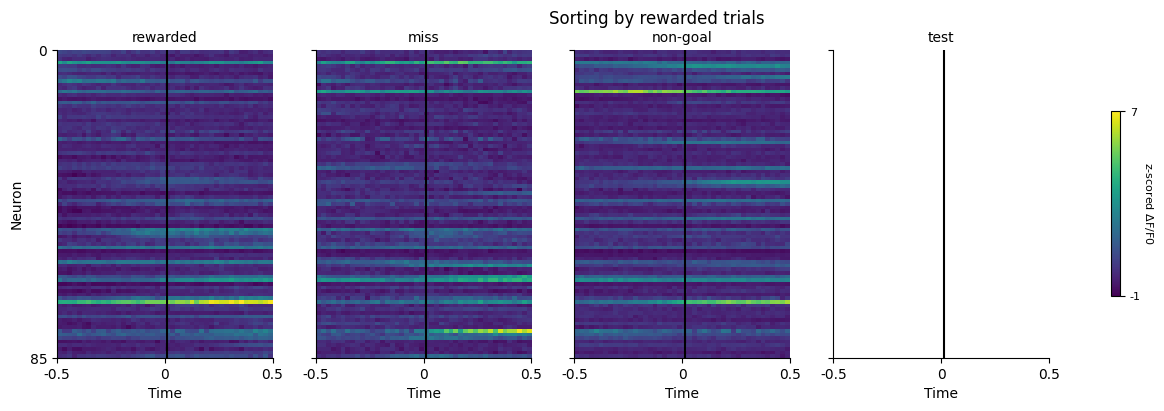

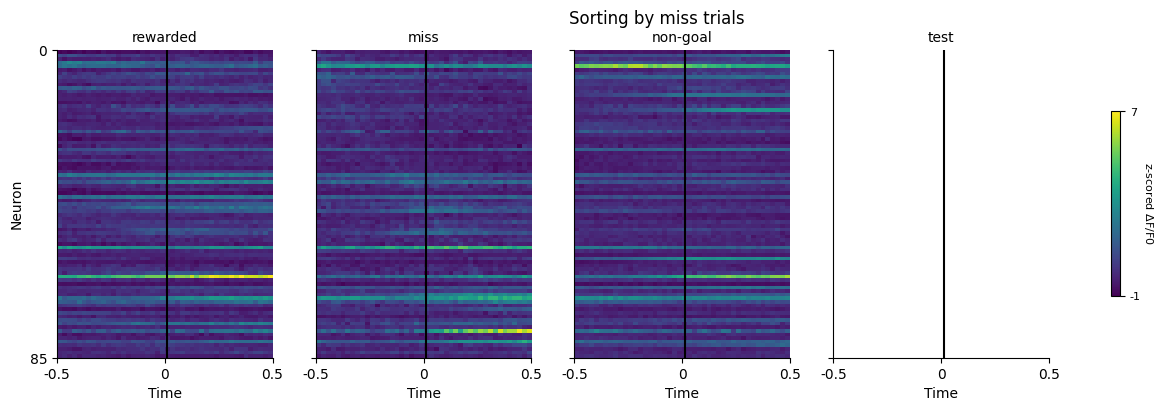

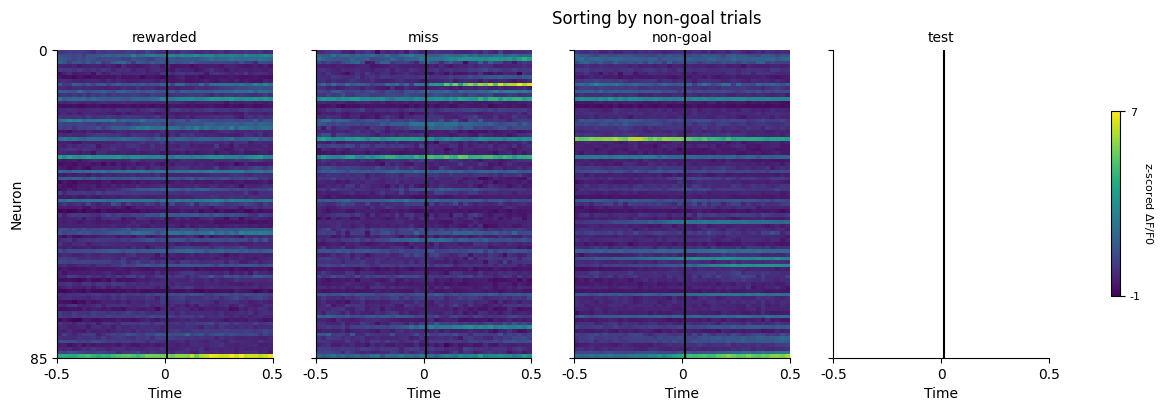

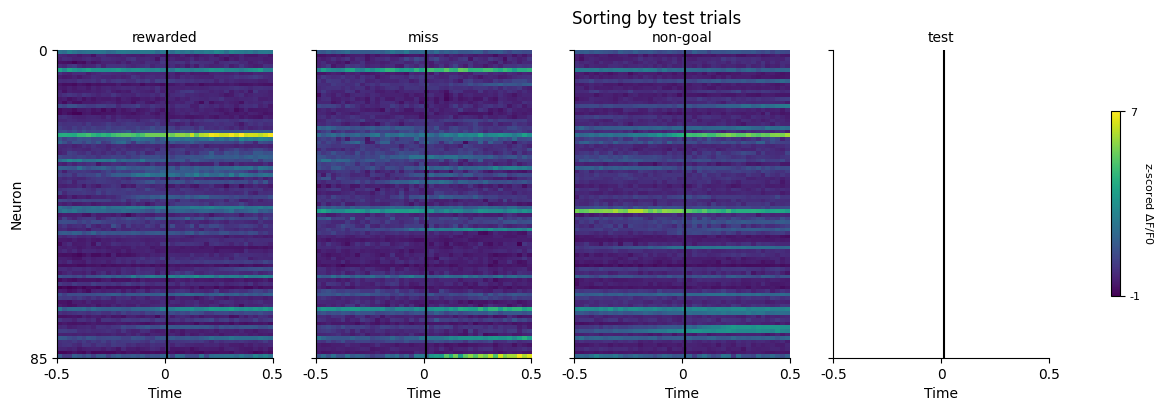

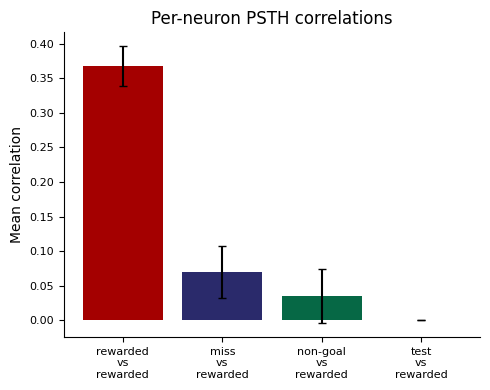

In [178]:
# Get map correlations across conditions
if reload_results:

    psths = [reward_psth[all_significant_neurons_reward,:], miss_psth, nongoal_psth, test_psth]
    average_psths = [average_reward_psth[all_significant_neurons_reward,:], average_miss_psth, average_nongoal_psth, average_test_psth]

    plot_condition_psth_map(average_psths=average_psths, conditions=conditions, zscoring=True, time_around=time_around, \
                            save_plot=True, savepath=save_path, savedir='RewardFiringMap_rew_miss_nongoal_test_RewardTunedNeurons')

    reward_corrs = get_map_correlation(psths=psths, average_psths=average_psths, conditions=conditions, \
                        zscoring=True, reference=0, color_scheme=hfs_palette[ids], save_plot=True, savepath=save_path, \
                            savedir='RewardFiringMap_rew_miss_nongoal_test_RewardTunedNeurons', filename='FiringMap_correlation')

    # reward_corrs = get_map_correlation(neurons=all_significant_neurons_reward, psths=psths, average_psths=average_psths, conditions=conditions, \
    #                     zscoring=True, reference=0, color_scheme=hfs_palette[ids], save_plot=False, savepath=save_path, \
    #                         savedir='RewardFiringMap_rew_miss_nongoal_test_RewardTunedNeurons', filename='FiringMap_correlation')

    results_rewards['reward_corrs'] = reward_corrs

In [179]:
# If t5, split session into sections approximately
if reload_results:

    if protocol_num == 5 and animal == 'TAA0000066':
        split_indices = {id: {} for id in ids}
        split_corrs = [[] for i in range(3)]

        for i in range(3):
            if i == 0:
                trials = np.arange(0, 70)   # laps 0-7
            elif i == 1:
                trials = np.arange(70, 200)     # laps 7-20
            elif i == 2:
                trials = np.arange(200, num_lms)   # laps 20-end

            for id in ids:
                if i == 0:
                    split_indices[id][i] = np.arange(0, len(np.array([i for i, idx in enumerate(all_reward_idx)
                                                                        if idx in event_indices[id] and 
                                                ((idx >= lm_entry_idx[trials[0]]) & (idx <= lm_entry_idx[trials[-1]+1]))])))
                elif i == 1:
                    split_indices[id][i] = np.arange(len(split_indices[id][i-1]), len(split_indices[id][i-1]) + 
                                                    len(np.array([idx for i, idx in enumerate(all_reward_idx) 
                                                                if idx in event_indices[id] and 
                                            ((idx >= lm_entry_idx[trials[0]]) & (idx <= lm_entry_idx[trials[-1]+1]))])))
                elif i == 2:
                    split_indices[id][i] = np.arange(sum(len(split_indices[id][j]) for j in range(i)), sum(len(split_indices[id][j]) for j in range(i)) + 
                                                    len(np.array([idx for i, idx in enumerate(all_reward_idx) 
                                                                if idx in event_indices[id] and 
                                            ((idx >= lm_entry_idx[trials[0]]) & (idx <= lm_entry_idx[trials[-1]]))])))   
                                
            split_psths = [psths[j][:, split_indices[id][i], :] for j, id in enumerate(ids)]
            split_average_psths = [np.mean(psth, axis=1) for psth in split_psths]

            split_corrs[i] = get_map_correlation(psths=split_psths, \
                                                average_psths=split_average_psths, conditions=conditions, \
                            zscoring=True, reference=0, color_scheme=hfs_palette[ids], save_plot=False, savepath=save_path, \
                                savedir='RewardFiringMap_rew_miss_nongoal_test_RewardTunedNeurons', filename=f'FiringMap_correlation_{i}')
            
        results_rewards['split_corrs'] = split_corrs

In [180]:
# Save results 
if reload_results:
    np.savez(save_filename, **results_rewards)

#### Landmark (position) entry PETH

In [24]:
# Find data idx closest to landmarks
window = 5
num_bins = 2*window

window_start_idx = []
window_end_idx = []

# lm_exit_idx = []
# for lm_end in landmarks[0:len(all_lms)][:,1]:
#     # Find nearest frame of landmark exit
#     lm_exit_idx.append(int(np.argmin(np.abs(positions - lm_end))))

# lm_entry_idx = []
for i, lm_pos in enumerate(total_lm_position):
    # Find nearest frame of landmark entry
    # lm_entry_idx.append(int(np.argmin(np.abs(positions - lm_pos)))) # TODO: depends on how the corridor is configured 
    
    window_start_idx.append(int(np.argmin(np.abs(positions - (lm_pos - window)))))
    window_end_idx.append(int(np.argmin(np.abs(positions - (lm_pos + window)))))

In [25]:
# Landmark PETH 
lm_firing_hist = np.zeros([num_neurons_considered, num_lms, num_bins])

# Frames and positions within the window for each landmark
window_frames = [np.arange(start, end + 1) for start, end in zip(window_start_idx, window_end_idx)]
window_positions = [np.arange(lm_pos - window, lm_pos + window + 1) for i, lm_pos in enumerate(total_lm_position)]

# Compute binning in a single batch operation for all neurons
for n, neuron in enumerate(neurons_considered):
    for lm in range(num_lms):
        lm_firing_hist[n, lm, :], _, _ = stats.binned_statistic(
            positions[window_frames[lm]],  
            DF_F[neuron, window_frames[lm]],  
            statistic='mean',
            bins=window_positions[lm]
        )

In [26]:
# Average binned firing rate by landmark id 
average_lm_firing_hist = np.zeros([num_neurons_considered, num_landmarks, num_bins])

for i in range(num_landmarks):
    average_lm_firing_hist[:, i, :] = np.mean(lm_firing_hist[:, i::10, :], axis=1)

    # TODO: z-score firing rates 
    # zscore_lm_firing_hist = zscore(average_lm_firing_hist[:, i, :])   
print(average_lm_firing_hist.shape)

(319, 10, 10)


In [27]:
# Average PETH for each cell and each landmark 
if num_laps == 1:  # the corridor didn't reset # TODO: fix for corridor resetting

    # sort cells according to firing around landmark 1
    sortidx = np.argsort(np.argmax(average_lm_firing_hist[:, 0, :], axis=1))
    
    fig, ax = plt.subplots(1, 10, figsize=(20, 5), sharey=True)
    ax = ax.ravel()

    for i in range(10):
        # sort cells according to firing around each landmark 
        # sortidx = np.argsort(np.argmax(average_lm_firing_hist[:, i, :], axis=1))  

        ax[i].imshow(average_lm_firing_hist[sortidx, i, :], aspect='auto')
        ax[i].vlines(window-0.5, ymin=-0.5, ymax=num_neurons_considered-0.5, color='k')
        ax[i].set_xlabel('Position')
        ax[i].set_xticks([-0.5, num_bins-0.5])
        ax[i].set_xticklabels([0, num_bins])
        ax[i].set_title(f'Landmark {i+1}')

    ax[0].set_ylabel('Neuron')
    ax[0].set_yticks([-0.5, num_neurons_considered-0.5])
    ax[0].set_yticklabels([0, num_neurons_considered])
    fig.suptitle('Firing rate map')
    plt.tight_layout()
    
    # plt.savefig(os.path.join(save_path, 'position_lm_peth_lm0-sorted.tiff'))
    # plt.savefig(os.path.join(save_path, 'position_lm_peth_lm0-sorted.png'))

In [28]:
# Split trials in half (randomly) to confirm landmark entry 'tuning'
lm = 0
lm_idx = np.where(all_lms == lm)[0]
num_sort_trials = np.floor(len(lm_idx)/2).astype(int)

random_lm0_sort = np.random.choice(lm_idx, num_sort_trials, replace=False)  # used for sorting
random_lm0_test = np.setdiff1d(lm_idx, random_lm0_sort)  # used for testing

# Average firing rates for sort trials and test trials separately
sort_lm_firing_hist = np.mean(lm_firing_hist[:, random_lm0_sort, :], axis=1)
test_lm_firing_hist = np.mean(lm_firing_hist[:, random_lm0_test, :], axis=1)

sortidx = np.argsort(np.argmax(sort_lm_firing_hist[:, :], axis=1))
    
fig, ax = plt.subplots(1, 2, figsize=(8, 5), sharey=True)
ax = ax.ravel()

ax[0].imshow(sort_lm_firing_hist[sortidx, :], aspect='auto')
ax[0].vlines(window-0.5, ymin=-0.5, ymax=num_neurons_considered-0.5, color='k')
ax[0].set_xlabel('Position')
ax[0].set_xticks([-0.5, num_bins-0.5])
ax[0].set_xticklabels([0, num_bins])
ax[0].set_title(f'Landmark {lm+1} sorting trials')

ax[1].imshow(test_lm_firing_hist[sortidx, :], aspect='auto')
ax[1].vlines(window-0.5, ymin=-0.5, ymax=num_neurons_considered-0.5, color='k')
ax[1].set_xlabel('Position')
ax[1].set_xticks([-0.5, num_bins-0.5])
ax[1].set_xticklabels([0, num_bins])
ax[1].set_title(f'Landmark {lm+1} testing trials')

ax[0].set_ylabel('Neuron')
ax[0].set_yticks([-0.5, num_neurons_considered-0.5])
ax[0].set_yticklabels([0, num_neurons_considered])
fig.suptitle('Firing rate map')
plt.tight_layout()

# plt.savefig(os.path.join(save_path, f'FiringMap_position_lm{lm+1}_random_trial_sorting.png'))

#### Landmark (time) entry PETH 

In [190]:
# Initialize saving variables
time_around = 0.5
save_filename = os.path.join(save_path, f'T{protocol_num}_lmEntry_analysis_{time_around}s.npz')
reload_results = False

if os.path.exists(save_filename) and not reload_results:
    print('Landmark entry anlaysis has already been performed. Loading...')
    results_lmEntry = np.load(save_filename, allow_pickle=True)
else: 
    reload_results = True
    results_lmEntry = {}

# Load variables that might be needed, if they exist
if os.path.exists(os.path.join(save_path, f'T{protocol_num}_rewards_analysis_{time_around}s.npz')):
    print('Reward anlaysis has already been performed. Loading...')
    results_rewards = np.load(os.path.join(save_path, f'T{protocol_num}_rewards_analysis_{time_around}s.npz'), allow_pickle=True)
    all_significant_neurons_reward = results_rewards['all_significant_neurons_reward']
else:
    print('Reward anlaysis has not been performed yet.')

Landmark entry anlaysis has already been performed. Loading...
Reward anlaysis has already been performed. Loading...


In [191]:
# Firing around time of landmark entry (for all landmarks)
if reload_results:
    
    lmEntry_psth, average_lmEntry_psth = get_psth(data=DF_F, neurons=neurons_considered, event_idx=lm_entry_idx, \
                                                            time_around=time_around, funcimg_frame_rate=funcimg_frame_rate)

    plot_avg_psth(average_psth=average_lmEntry_psth, event='Time of landmark entry', \
                zscoring=True, time_around=time_around, funcimg_frame_rate=funcimg_frame_rate)

    split_psth(psth=lmEntry_psth, event_idx=lm_entry_idx, event='Time of landmark entry', \
            zscoring=True, time_around=time_around, funcimg_frame_rate=funcimg_frame_rate)

    # Get landmark entry-tuned neurons
    significant_neurons_lmEntry = get_tuned_neurons(average_lmEntry_psth, event='time of landmark entry', \
                    time_around=time_around, funcimg_frame_rate=funcimg_frame_rate, plot_neurons=False)

    results_lmEntry['lmEntry_psth'] = lmEntry_psth
    results_lmEntry['average_lmEntry_psth'] = average_lmEntry_psth
    results_lmEntry['significant_neurons_lmEntry'] = significant_neurons_lmEntry

In [ ]:
# Find landmark-specific landmark entry-tuned neurons
if reload_results:
    
    if protocol_num >= 5:
        lmEntry_landmark_psth, average_lmEntry_landmark_psth = get_landmark_psth(data=DF_F, neurons=neurons_considered, event_idx=lm_entry_idx, \
                                                            num_landmarks=num_landmarks, time_around=time_around)

        significant_neurons_lmEntry_landmark = [[] for _ in range(num_landmarks)]
        for i in range(num_landmarks):
            significant_neurons_lmEntry_landmark[i] = get_tuned_neurons(average_lmEntry_landmark_psth[:, i, :], event=f'time of landmark {i+1} entry', \
                            time_around=time_around, plot_neurons=False)

    else:
        _, average_lmEntry_landmark_psth = get_landmark_id_psth(data=DF_F, neurons=neurons_considered, event_idx=lm_entry_idx, \
                                                            session=session, num_landmarks=num_landmarks, time_around=time_around)
        
        significant_neurons_lmEntry_landmark = [[] for _ in range(num_landmarks)]
        for i in range(num_landmarks):
            lm = session['all_lms'][session['goals_idx'][0]] if i == 0 else session['all_lms'][session['non_goals_idx'][0]] 
            significant_neurons_lmEntry_landmark[i] = get_tuned_neurons(average_lmEntry_landmark_psth[:, i, :], event=f'time of landmark {lm+1} entry', \
                            time_around=time_around, plot_neurons=False)

    all_significant_neurons_lmEntry = np.array(sorted(set(neuron for lm in significant_neurons_lmEntry_landmark for neuron in lm)))
    print(f'{len(all_significant_neurons_lmEntry)} neurons are tuned to (any) landmark entry.')

    results_lmEntry['lmEntry_landmark_psth'] = lmEntry_landmark_psth
    results_lmEntry['average_lmEntry_landmark_psth'] = average_lmEntry_landmark_psth
    results_lmEntry['significant_neurons_lmEntry_landmark'] = significant_neurons_lmEntry_landmark
    results_lmEntry['all_significant_neurons_lmEntry'] = all_significant_neurons_lmEntry

In [193]:
# Plot firing maps of all landmark entry-tuned neurons, sorted by specific landmark 
if reload_results:
    
    plot_landmark_psth_map(average_psth=average_lmEntry_landmark_psth[all_significant_neurons_lmEntry], session=session, \
                        zscoring=True, sorting_lm=0, num_landmarks=num_landmarks, time_around=time_around, \
                            save_plot=False, savepath=save_path, filename='FiringMap_lmAll_LmEntryTimeTunedNeurons')
    

##### Compare average landmark entry PSTH map in rewarded vs non-goal landmark vs ‘test’ vs miss goal landmarks (because of high speed or no licking)

In [ ]:
# Get PSTHs for types of landmarks
if reload_results:

    conditions = ['rewarded', 'lick & miss', 'miss', 'non-goal', 'test']
    ids = [1,2,8,3,4]
    event_indices = {}

    if len(miss_lm_entry_idx) > 0:
        lick_miss_lm_entry_idx = np.concatenate([miss_lm_entry_idx[miss_lm_entry_idx == lm_entry_idx[i]]
                        for i in range(len(lm_entry_idx)) if i in session['goals_idx'] and i not in rewarded_landmarks 
                        and np.any((lick_idx >= lm_entry_idx[i]) & (lick_idx <= lm_exit_idx[i]))]).astype(int)

        nolick_miss_lm_entry_idx = np.concatenate([miss_lm_entry_idx[miss_lm_entry_idx == lm_entry_idx[i]]
                        for i in range(len(lm_entry_idx)) if i in session['goals_idx'] and i not in rewarded_landmarks 
                        and not np.any((lick_idx >= lm_entry_idx[i]) & (lick_idx <= lm_exit_idx[i]))]).astype(int)

    else:
        lick_miss_lm_entry_idx = np.array([], dtype=int)
        nolick_miss_lm_entry_idx = np.array([], dtype=int)


    for id in ids:
        if id == 1:
            event_indices[id] = np.array(rew_lm_entry_idx)
        elif id == 2:
            event_indices[id] = lick_miss_lm_entry_idx
        elif id == 8:
            event_indices[id] = nolick_miss_lm_entry_idx
        elif id == 3:
            event_indices[id] = nongoal_lm_entry_idx
        elif id == 4:
            event_indices[id] = test_lm_entry_idx

    assert len(np.concatenate([event_indices[id] for id in ids])) == len(lm_entry_idx), 'Some landmarks have not been considered.'

    rew_lm_psth, average_rew_lm_psth = get_psth(data=DF_F, neurons=neurons_considered[all_significant_neurons_reward], \
                                                                    event_idx=event_indices[1], time_around=time_around)

    lick_miss_lm_psth, average_lick_miss_lm_psth = get_psth(data=DF_F, neurons=neurons_considered[all_significant_neurons_reward], \
                                                                    event_idx=event_indices[2], time_around=time_around)

    nolick_miss_lm_psth, average_nolick_miss_lm_psth = get_psth(data=DF_F, neurons=neurons_considered[all_significant_neurons_reward], \
                                                                    event_idx=event_indices[8], time_around=time_around)

    nongoal_lm_psth, average_nongoal_lm_psth = get_psth(data=DF_F, neurons=neurons_considered[all_significant_neurons_reward], \
                                                                    event_idx=event_indices[3], time_around=time_around)

    test_lm_psth, average_test_lm_psth = get_psth(data=DF_F, neurons=neurons_considered[all_significant_neurons_reward], \
                                                                    event_idx=event_indices[4], time_around=time_around)

    results_lmEntry['rew_lm_psth'] = rew_lm_psth
    results_lmEntry['average_rew_lm_psth'] = average_rew_lm_psth
    results_lmEntry['lick_miss_lm_psth'] = lick_miss_lm_psth
    results_lmEntry['average_lick_miss_lm_psth'] = average_lick_miss_lm_psth
    results_lmEntry['nolick_miss_lm_psth'] = nolick_miss_lm_psth
    results_lmEntry['average_nolick_miss_lm_psth'] = average_nolick_miss_lm_psth
    results_lmEntry['nongoal_lm_psth'] = nongoal_lm_psth
    results_lmEntry['average_nongoal_lm_psth'] = average_nongoal_lm_psth
    results_lmEntry['test_lm_psth'] = test_lm_psth
    results_lmEntry['average_test_lm_psth'] = average_test_lm_psth

In [195]:
# Get map correlations across conditions
if reload_results:

    psths = [rew_lm_psth, lick_miss_lm_psth, nolick_miss_lm_psth, nongoal_lm_psth, test_lm_psth]
    average_psths = [average_rew_lm_psth, average_lick_miss_lm_psth, average_nolick_miss_lm_psth, average_nongoal_lm_psth, average_test_lm_psth]

    plot_condition_psth_map(average_psths=average_psths, conditions=conditions, zscoring=True, time_around=time_around, \
                            save_plot=False, savepath=save_path, savedir='LmEntryFiringMap_rew_miss_nongoal_test_RewardTunedNeurons')

    lmEntry_corrs = get_map_correlation(psths=psths, average_psths=average_psths, conditions=conditions, \
                        zscoring=True, reference=0, color_scheme=hfs_palette[np.array(ids)-1], save_plot=False, savepath=save_path, \
                            savedir='LmEntryFiringMap_rew_miss_nongoal_test_RewardTunedNeurons', filename='FiringMap_correlation')

    results_lmEntry['lmEntry_corrs'] = lmEntry_corrs

In [196]:
# If t5, split session into sections approximately
if reload_results:

    if protocol_num == 5 and animal == 'TAA0000066':
        split_indices = {id: {} for id in ids}
        split_corrs = [[] for i in range(3)]

        for i in range(3):
            if i == 0:
                trials = np.arange(0, 70)   # laps 0-7
            elif i == 1:
                trials = np.arange(70, 200)     # laps 7-20
            elif i == 2:
                trials = np.arange(200, num_lms)   # laps 20-end

            for id in ids:
                if i == 0:
                    split_indices[id][i] = np.arange(0, len(np.array([i for i, idx in enumerate(lm_entry_idx)
                                                                        if idx in event_indices[id] and 
                                                ((idx >= lm_entry_idx[trials[0]]) & (idx <= lm_entry_idx[trials[-1]]))])))
                elif i == 1:
                    split_indices[id][i] = np.arange(len(split_indices[id][i-1]), len(split_indices[id][i-1]) + 
                                                    len(np.array([idx for i, idx in enumerate(lm_entry_idx) 
                                                                if idx in event_indices[id] and 
                                            ((idx >= lm_entry_idx[trials[0]]) & (idx <= lm_entry_idx[trials[-1]]))])))
                elif i == 2:
                    split_indices[id][i] = np.arange(sum(len(split_indices[id][j]) for j in range(i)), sum(len(split_indices[id][j]) for j in range(i)) + 
                                                    len(np.array([idx for i, idx in enumerate(lm_entry_idx) 
                                                                if idx in event_indices[id] and 
                                            ((idx >= lm_entry_idx[trials[0]]) & (idx <= lm_entry_idx[trials[-1]]))])))   

            split_psths = [psths[j][:, split_indices[id][i], :] for j, id in enumerate(ids)]
            split_average_psths = [np.mean(psth, axis=1) for psth in split_psths]

            split_corrs[i] = get_map_correlation(psths=split_psths, average_psths=split_average_psths, conditions=conditions, \
                            zscoring=True, reference=0, color_scheme=hfs_palette[np.array(ids)-1], save_plot=False, savepath=save_path, \
                                savedir='LmEntryFiringMap_rew_miss_nongoal_test_RewardTunedNeurons', filename=f'FiringMap_correlation_{i}')
            
        results_lmEntry['split_corrs'] = split_corrs

In [197]:
# Save results 
if reload_results:
    np.savez(save_filename, **{k: np.array(v, dtype=object) for k, v in results_lmEntry.items()})

#### Lick PSTH

In [210]:
# Initialize saving variables
time_around = 0.5
save_filename = os.path.join(save_path, f'T{protocol_num}_licks_analysis_{time_around}s.npz')
reload_results = False

if os.path.exists(save_filename) and not reload_results:
    print('Lick anlaysis has already been performed. Loading...')
    results_licks = np.load(save_filename, allow_pickle=True)
else: 
    reload_results = True
    results_licks = {}

# Load variables that might be needed, if they exist
if os.path.exists(os.path.join(save_path, f'T{protocol_num}_rewards_analysis_{time_around}s.npz')):
    print('Reward anlaysis has already been performed. Loading...')
    results_rewards = np.load(os.path.join(save_path, f'T{protocol_num}_rewards_analysis_{time_around}s.npz'), allow_pickle=True)
    all_significant_neurons_reward = results_rewards['all_significant_neurons_reward']
else:
    print('Reward anlaysis has not been performed yet.')

Reward anlaysis has already been performed. Loading...


##### Split licks into types 
* 1: licks inside goal landmarks & rewarded (hit)
* 2: licks inside goal landmarks & not rewarded (miss)
* 3: licks inside non-goal landmarks (false alarm)
* 4: licks inside test landmark
* 5: licks before goal landmarks 
* 6: licks before non-goal landmarks 
* 7: licks before test landmark
* 8: imaginary lick inside goal (miss)

In [ ]:
# Collect all licks 
licks = {id: {} for id in range(1,9)}

for id in range(1,9):
    collected_licks = []  
    
    if id == 1:
        collected_licks = [
            lick_idx[(lick_idx >= lm_entry_idx[i]) & (lick_idx <= lm_exit_idx[i])]
            for i in range(len(lm_entry_idx)) if i in rewarded_landmarks
        ]

    elif id == 2:
        collected_licks = [
            lick_idx[(lick_idx >= lm_entry_idx[i]) & (lick_idx <= lm_exit_idx[i])]
            for i in range(len(lm_entry_idx)) if i in session['goals_idx'] and i not in rewarded_landmarks
        ]

    elif id == 3:
        collected_licks = [
            lick_idx[(lick_idx >= lm_entry_idx[i]) & (lick_idx <= lm_exit_idx[i])]
            for i in range(len(lm_entry_idx)) if i in session['non_goals_idx']
        ]

    elif id == 4:
        collected_licks = [
            lick_idx[(lick_idx >= lm_entry_idx[i]) & (lick_idx <= lm_exit_idx[i])]
            for i in range(len(lm_entry_idx)) if i in session['test_idx']
        ]

    elif id == 5:
        if 0 in session['goals_idx']:
            collected_licks.append(lick_idx[lick_idx < lm_entry_idx[0]])
        collected_licks += [
            lick_idx[(lick_idx > lm_exit_idx[i]) & (lick_idx < lm_entry_idx[i + 1])]
            for i in range(len(lm_entry_idx) - 1) if i + 1 in session['goals_idx']
        ]

    elif id == 6:
        if 0 in session['non_goals_idx']:
            collected_licks.append(lick_idx[lick_idx < lm_entry_idx[0]])
        collected_licks += [
            lick_idx[(lick_idx > lm_exit_idx[i]) & (lick_idx < lm_entry_idx[i + 1])]
            for i in range(len(lm_entry_idx) - 1) if i + 1 in session['non_goals_idx']
        ]

    elif id == 7:
        if 0 in session['test_idx']:
            collected_licks.append(lick_idx[lick_idx < lm_entry_idx[0]])  
        collected_licks += [
            lick_idx[(lick_idx > lm_exit_idx[i]) & (lick_idx < lm_entry_idx[i + 1])]
            for i in range(len(lm_entry_idx) - 1) if i + 1 in session['test_idx']
        ]

    elif id == 8:
        collected_licks = [
            session['miss_rew_idx'][(session['miss_rew_idx'] >= lm_entry_idx[i]) & (session['miss_rew_idx'] <= lm_exit_idx[i])]
            for i in range(len(lm_entry_idx)) if i in session['goals_idx'] and i not in rewarded_landmarks 
            and not np.any((lick_idx >= lm_entry_idx[i]) & (lick_idx <= lm_exit_idx[i]))
        ]

    if collected_licks:
        licks[id] = np.concatenate(collected_licks).astype(int)
    else:
        licks[id] = np.array([], dtype=int)
        
all_licks = np.sort(np.concatenate([licks[id] for id in range(1,8)]))
all_and_imag_licks = np.sort(np.concatenate([licks[id] for id in range(1,9)]))

# Array of lick ids 
# lick_ids = np.zeros((len(all_and_imag_lick_idx), 1))
# lick_ids[np.where(np.isin(all_and_imag_lick_idx, licks1))[0]] = 1
# lick_ids[np.where(np.isin(all_and_imag_lick_idx, licks2))[0]] = 2
# lick_ids[np.where(np.isin(all_and_imag_lick_idx, licks3))[0]] = 3
# lick_ids[np.where(np.isin(all_and_imag_lick_idx, licks4))[0]] = 4
# lick_ids[np.where(np.isin(all_and_imag_lick_idx, licks5))[0]] = 5
# lick_ids[np.where(np.isin(all_and_imag_lick_idx, licks6))[0]] = 6
# lick_ids[np.where(np.isin(all_and_imag_lick_idx, licks7))[0]] = 7
# lick_ids[np.where(np.isin(all_and_imag_lick_idx, licks8))[0]] = 8

# lick_ids = lick_ids.flatten()

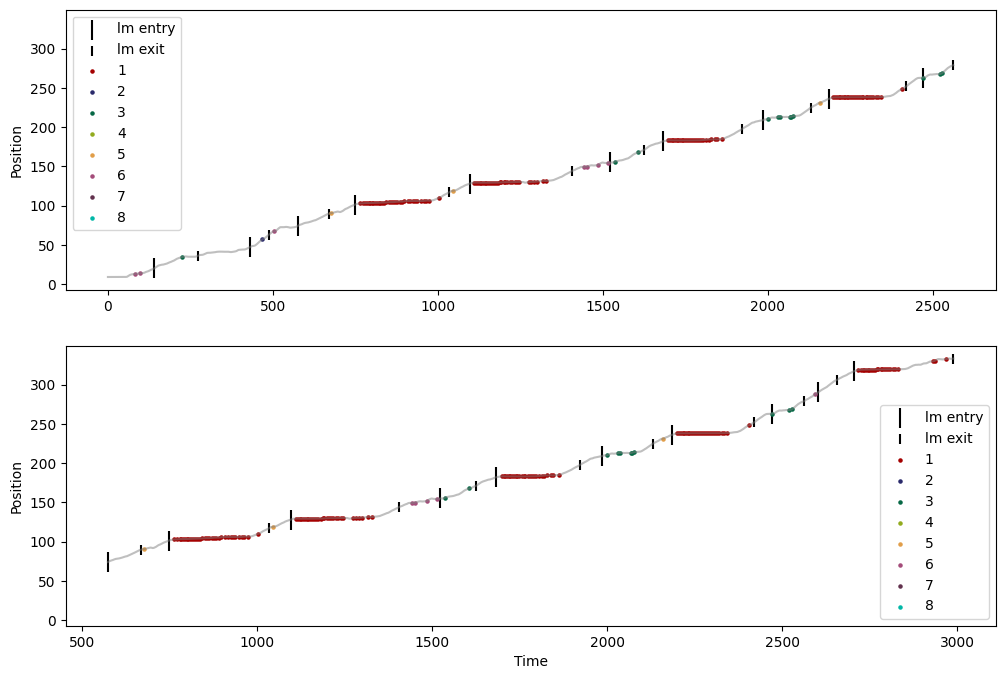

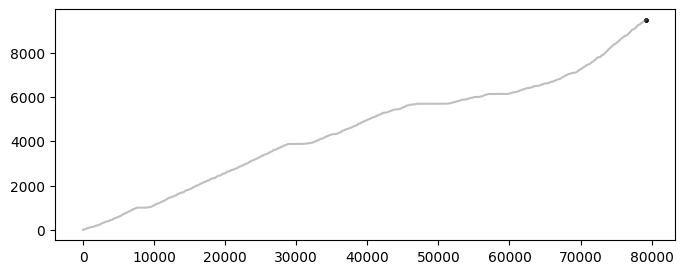

In [212]:
# Visually confirm the lick IDs make sense
example_runs = [np.arange(0, lm_exit_idx[9]+1), np.arange(lm_entry_idx[rewarded_landmarks[0]-1], lm_exit_idx[rewarded_landmarks[3]+3]+1)]

fig, ax = plt.subplots(2, 1, figsize=(12,8), sharey=True)
ax = ax.ravel()

for i in range(2):
    entries = np.array(lm_entry_idx)[(np.array(lm_entry_idx) >= example_runs[i][0]) & (np.array(lm_entry_idx) <= example_runs[i][-1])]
    exits = np.array(lm_exit_idx)[(np.array(lm_exit_idx) >= example_runs[i][0]) & (np.array(lm_exit_idx) <= example_runs[i][-1])]
    
    ax[i].plot(example_runs[i], data['position'][example_runs[i]], color='gray', alpha=0.5)
    ax[i].scatter(entries, data['position'][entries], s=200, marker='|', color='k', label='lm entry')
    ax[i].scatter(exits, data['position'][exits], s=50, marker='|', color='k', label='lm exit')
    
    for id in range(1,9):
        licks_in_range = licks[id][(licks[id] >= example_runs[i][0]) & (licks[id] <= example_runs[i][-1])]
        ax[i].scatter(licks_in_range, data['position'][licks_in_range], s=5, color=hfs_palette[id-1], label=f'{id}')
    
    ax[i].legend()
    ax[i].set_ylabel('Position')
ax[1].set_xlabel('Time')

# Make sure the missing licks are only at the very end 
missing_licks = np.setxor1d(lick_idx, all_licks)
fig, ax = plt.subplots(1, 1, figsize=(8,3))
ax.plot(data['position'], color='gray', alpha=0.5)
ax.scatter(missing_licks, data['position'][missing_licks], s=5, color='k')

In [ ]:
# Find first licks for each type 
first_licks = {}

for id in range(1,9):
    if id == 1:
        first_licks[id] = np.array([lick_idx[(lick_idx >= entry) & (lick_idx <= exit)][0]
                for i, (entry, exit) in enumerate(zip(lm_entry_idx, lm_exit_idx))
                if i in rewarded_landmarks and np.any((lick_idx >= entry) & (lick_idx <= exit))])
        
    elif id == 2:
        first_licks[id] = np.array([lick_idx[(lick_idx >= entry) & (lick_idx <= exit)][0]
                 for i, (entry, exit) in enumerate(zip(lm_entry_idx, lm_exit_idx))
                  if i in session['goals_idx'] and i not in rewarded_landmarks and np.any((lick_idx >= entry) & (lick_idx <= exit))])
        
    elif id == 3:
        first_licks[id] = np.array([lick_idx[(lick_idx >= entry) & (lick_idx <= exit)][0]
                 for i, (entry, exit) in enumerate(zip(lm_entry_idx, lm_exit_idx))
                  if i in session['non_goals_idx'] and np.any((lick_idx >= entry) & (lick_idx <= exit))])
        
    elif id == 4:
        first_licks[id] = np.array([lick_idx[(lick_idx >= entry) & (lick_idx <= exit)][0]
                 for i, (entry, exit) in enumerate(zip(lm_entry_idx, lm_exit_idx))
                  if i in session['test_idx'] and np.any((lick_idx >= entry) & (lick_idx <= exit))])
        
    elif id == 5:
        licks5 = []
        if 0 in session['goals_idx']:
            if np.any(lick_idx < lm_entry_idx[0]):
                licks5.append(lick_idx[lick_idx < lm_entry_idx[0]][0])
        licks5 += [
            lick_idx[(lick_idx > lm_exit_idx[i]) & (lick_idx < lm_entry_idx[i + 1])][0]
            for i in range(len(lm_entry_idx) - 1)
            if i + 1 in session['goals_idx'] and np.any((lick_idx > lm_exit_idx[i]) & (lick_idx < lm_entry_idx[i + 1]))
        ]
        first_licks[id] = np.array(licks5)

    elif id == 6:
        licks6 = []
        if 0 in session['non_goals_idx']:
            if np.any(lick_idx < lm_entry_idx[0]):
                licks6.append(lick_idx[lick_idx < lm_entry_idx[0]][0])
        licks6 += [
            lick_idx[(lick_idx > lm_exit_idx[i]) & (lick_idx < lm_entry_idx[i + 1])][0]
            for i in range(len(lm_entry_idx) - 1)
            if i + 1 in session['non_goals_idx'] and np.any((lick_idx > lm_exit_idx[i]) & (lick_idx < lm_entry_idx[i + 1]))
        ]
        first_licks[id] = np.array(licks6)

    elif id == 7:
        licks7 = []
        if 0 in session['test_idx']:
            if np.any(lick_idx < lm_entry_idx[0]):
                licks7.append(lick_idx[lick_idx < lm_entry_idx[0]][0])
        licks7 += [
            lick_idx[(lick_idx > lm_exit_idx[i]) & (lick_idx < lm_entry_idx[i + 1])][0]
            for i in range(len(lm_entry_idx) - 1)
            if i + 1 in session['test_idx'] and np.any((lick_idx > lm_exit_idx[i]) & (lick_idx < lm_entry_idx[i + 1]))
        ]
        first_licks[id] = np.array(licks7)

    elif id == 8: 
        first_licks[id] = licks[id]

all_first_licks = np.sort(np.concatenate([first_licks[id] for id in range(1,9)]))
print('Number of licks considered:', len(all_first_licks))

Number of licks considered: 297


In [259]:
# Find the maximum time-window during which the animal is between landmarks
# time_around = 0.5
# time_window = time_around * funcimg_frame_rate # frames
# num_timebins = 2*time_window

# print(len(first_licks[5]))
# for l, lick in enumerate(first_licks[5]):
#     prev_landmark_idx = np.where(lm_exit_idx < lick)[0][-1]
#     next_landmark_idx = np.where(lm_entry_idx > lick)[0][0]

#     # Check if any landmark contains the anticipatory lick window
#     in_landmark = [
#         (lm_entry_idx[next_landmark_idx] <= lick + time_window) or (lm_exit_idx[prev_landmark_idx] >= lick - time_window)
        
#     ]
#     if any(in_landmark):
#         print(l, lick-time_window, lick+time_window)

##### Compare average lick PSTH map in goal vs non-goal vs ‘test’ vs miss goal landmarks (because of high speed or no licking) for reward-tuned neurons

In [216]:
# Get lick PSTH
if reload_results:
    
    conditions = ['rewarded', 'lick & miss', 'miss', 'non-goal', 'test']
    ids = [1,2,8,3,4]

    lick_psth = {}
    average_lick_psth = {}

    for id in ids:
        event_idx = np.array([idx for i, idx in enumerate(all_first_licks) if idx in licks[id]])
        
        lick_psth[id], average_lick_psth[id] = get_psth(data=DF_F, neurons=neurons_considered[all_significant_neurons_reward], \
                                                                    event_idx=event_idx, time_around=time_around)
        
    results_licks['lick_psth'] = lick_psth
    results_licks['average_lick_psth'] = average_lick_psth

/Users/athinaapostolelli/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning:

Mean of empty slice.

/Users/athinaapostolelli/.local/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning:

invalid value encountered in divide



/Users/athinaapostolelli/Documents/SWC/VR_ABCD_project/VR_ABCD/neural_analysis_helpers.py:642: RuntimeWarning:

All-NaN slice encountered

/Users/athinaapostolelli/Documents/SWC/VR_ABCD_project/VR_ABCD/neural_analysis_helpers.py:643: RuntimeWarning:

All-NaN slice encountered



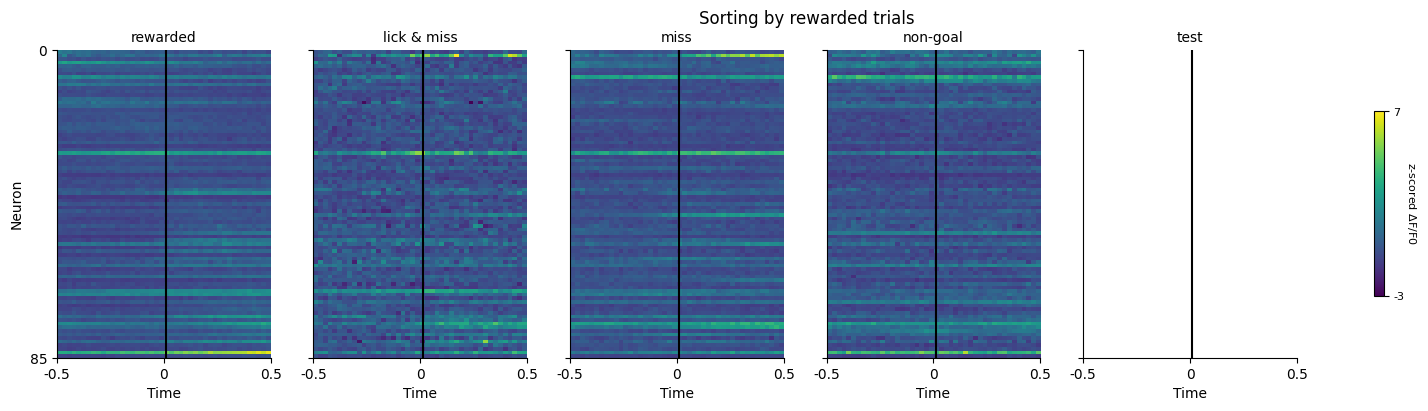

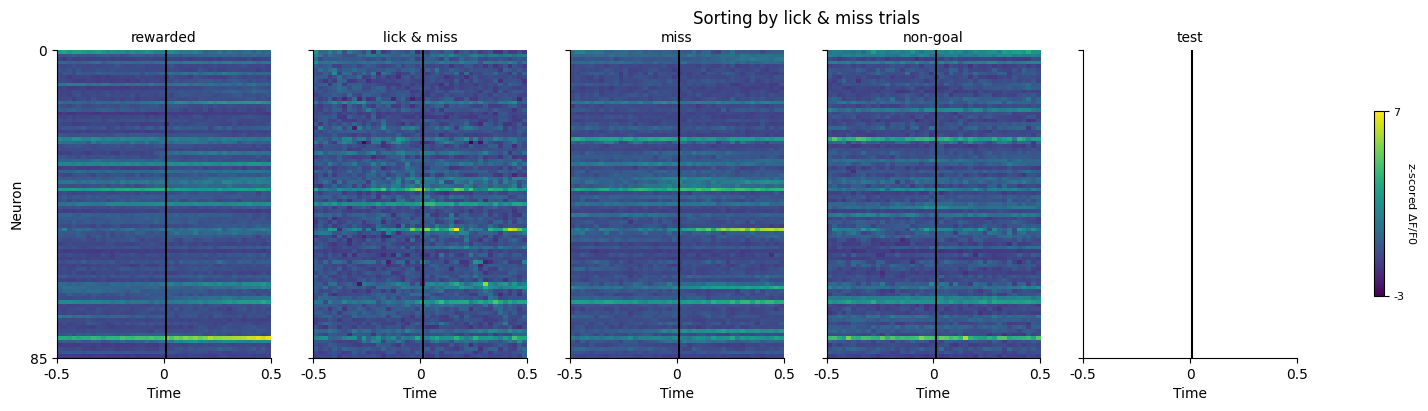

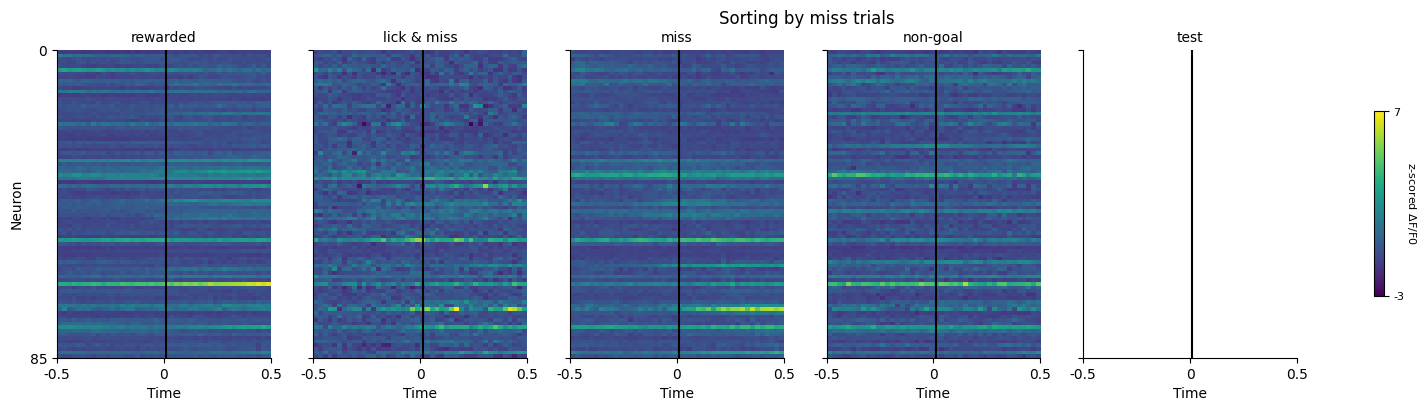

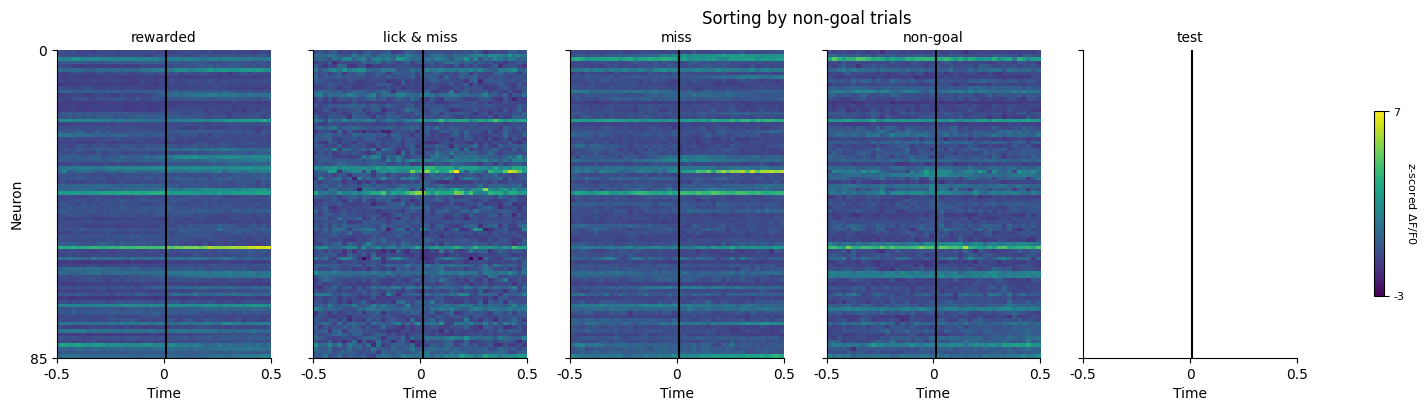

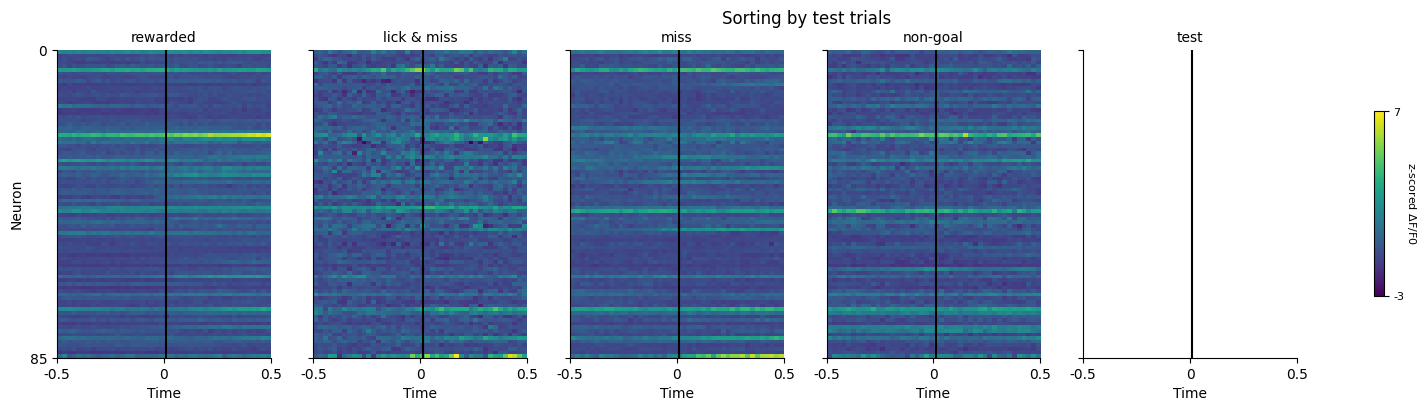

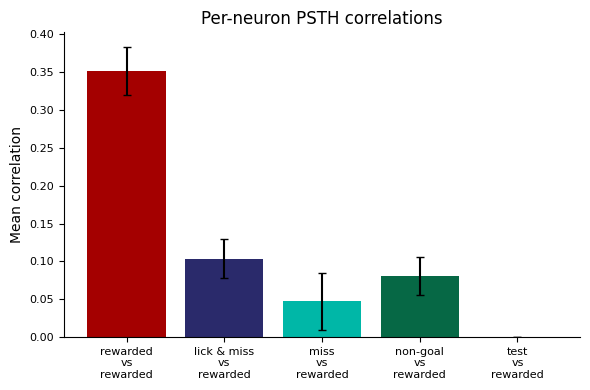

In [ ]:
# Get map correlations across conditions
if reload_results:

    psths = [lick_psth[id] for id in ids]
    average_psths = [average_lick_psth[id] for id in ids]

    plot_condition_psth_map(average_psths=average_psths, conditions=conditions, zscoring=True, time_around=time_around, \
                            save_plot=False, savepath=save_path, savedir='LickFiringMap_rew_miss_nongoal_test_RewardTunedNeurons')

    licks_corrs = get_map_correlation(psths=psths, average_psths=average_psths, conditions=conditions, \
                        zscoring=True, reference=0, color_scheme=hfs_palette[np.array(ids)-1], save_plot=False, savepath=save_path, \
                            savedir='LickFiringMap_rew_miss_nongoal_test_RewardTunedNeurons', filename='FiringMap_correlation')

    results_licks['licks_corrs'] = licks_corrs

In [219]:
# If t5, split session into sections approximately
if reload_results:

    if protocol_num == 5 and animal == 'TAA0000066':
        split_indices = {id: {} for id in ids}
        split_corrs = [[] for i in range(3)]

        for i in range(3):
            if i == 0:
                trials = np.arange(0, 70)   # laps 0-7
            elif i == 1:
                trials = np.arange(70, 200)     # laps 7-20
            elif i == 2:
                trials = np.arange(200, num_lms)   # laps 20-end

            for id in ids:
                if i == 0:
                    split_indices[id][i] = np.arange(0, len(np.array([i for i, idx in enumerate(all_first_licks)
                                                                        if idx in licks[id] and 
                                                ((idx >= lm_entry_idx[trials[0]]) & (idx <= lm_entry_idx[trials[-1]+1]))])))
                elif i == 1:
                    split_indices[id][i] = np.arange(len(split_indices[id][i-1]), len(split_indices[id][i-1]) + 
                                                    len(np.array([idx for i, idx in enumerate(all_first_licks) 
                                                                if idx in licks[id] and 
                                            ((idx >= lm_entry_idx[trials[0]]) & (idx <= lm_entry_idx[trials[-1]+1]))])))
                elif i == 2:
                    split_indices[id][i] = np.arange(sum(len(split_indices[id][j]) for j in range(i)), sum(len(split_indices[id][j]) for j in range(i)) + 
                                                    len(np.array([idx for i, idx in enumerate(all_first_licks) 
                                                                if idx in licks[id] and 
                                            ((idx >= lm_entry_idx[trials[0]]) & (idx <= lm_entry_idx[trials[-1]]))])))   
                                
            split_psths = [psths[j][:, split_indices[id][i], :] for j, id in enumerate(ids)]
            split_average_psths = [np.mean(psth, axis=1) for psth in split_psths]

            split_corrs[i] = get_map_correlation(psths=split_psths, average_psths=split_average_psths, conditions=conditions, \
                            zscoring=True, reference=0, color_scheme=hfs_palette[np.array(ids)-1], save_plot=False, savepath=save_path, \
                                savedir='LickFiringMap_rew_miss_nongoal_test_RewardTunedNeurons', filename=f'FiringMap_correlation_{i}')
            
        results_licks['split_corrs'] = split_corrs

##### Compare average lick PSTH map in rewarded goal (in landmark) vs anticipatory goal (outside landmark) vs miss goal landmarks (because of high speed or no licking) for reward-tuned neurons

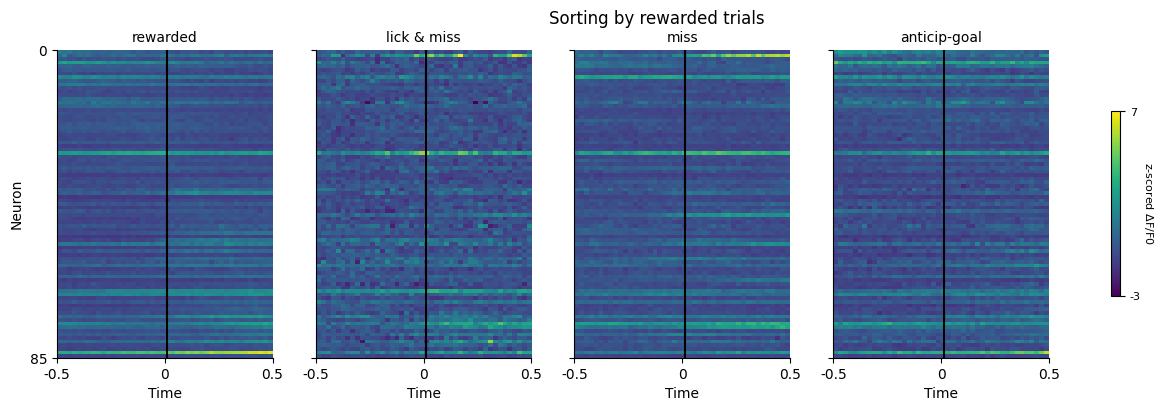

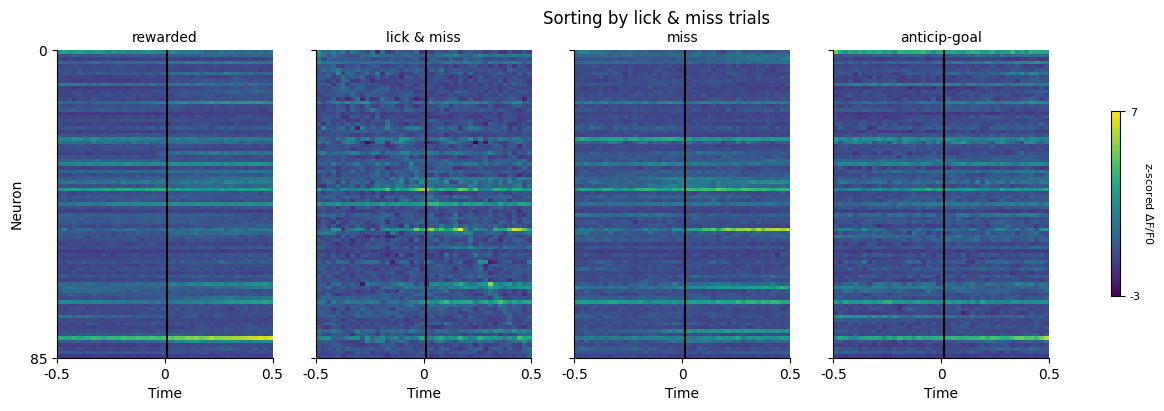

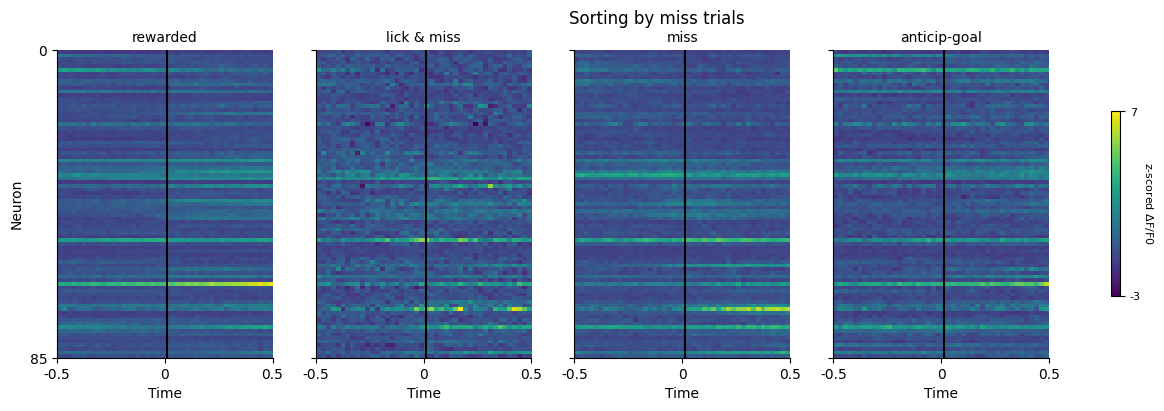

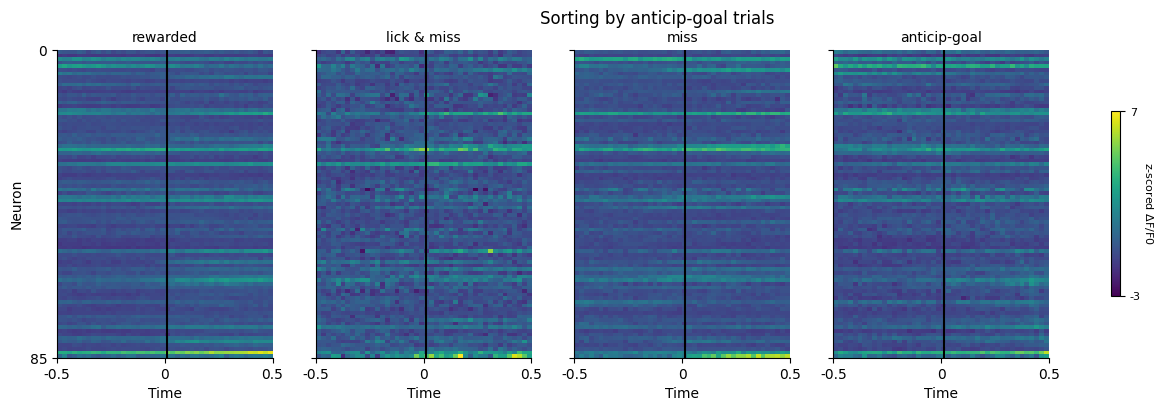

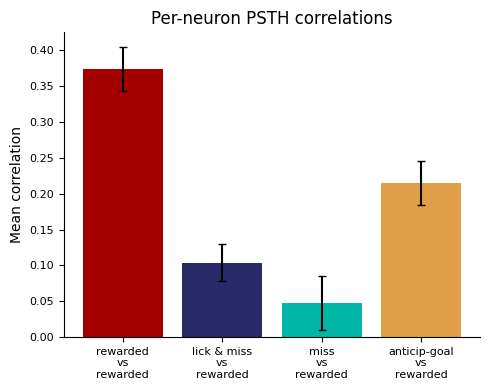

In [ ]:
if reload_results:

    conditions = ['rewarded', 'lick & miss', 'miss', 'anticip-goal']
    ids = [1,2,8,5]

    lick_psth = {}
    average_lick_psth = {}

    for id in ids:
        event_idx = np.array([idx for i, idx in enumerate(all_first_licks) if idx in licks[id]])
        
        lick_psth[id], average_lick_psth[id] = get_psth(data=DF_F, neurons=neurons_considered[all_significant_neurons_reward], \
                                                                    event_idx=event_idx, time_around=time_around)
        
    # Get map correlations across conditions
    psths = [lick_psth[id] for id in ids]
    average_psths = [average_lick_psth[id] for id in ids]

    plot_condition_psth_map(average_psths=average_psths, conditions=conditions, zscoring=True, time_around=time_around, \
                            save_plot=False, savepath=save_path, savedir='LickFiringMap_rew_miss_anticip_RewardTunedNeurons')

    _ = get_map_correlation(psths=psths, average_psths=average_psths, conditions=conditions, \
                        zscoring=True, reference=0, color_scheme=hfs_palette[np.array(ids)-1], save_plot=False, savepath=save_path, \
                            savedir='LickFiringMap_rew_miss_anticip_RewardTunedNeurons', filename='FiringMap_correlation')


In [222]:
# Save results 
if reload_results:
    np.savez(save_filename, **{k: np.array(v, dtype=object) for k, v in results_licks.items()})

#### Speed (and acceleration) analysis

In [223]:
# Initialize saving variables
save_filename = os.path.join(save_path, f'T{protocol_num}_speed_analysis.npz')
reload_results = False

if os.path.exists(save_filename) and not reload_results:
    results_speed = np.load(save_filename, allow_pickle=True)
else: 
    reload_results = True
    results_speed = {}

In [224]:
# Bin speed 
# TODO: change the number of bins? 
if reload_results:
    
    speed = data['speed']
    binned_speed = np.linspace(speed.min(), speed.max(), 21)
    # print(binned_speed) 

    # Bin acceleration
    # dt = 1 / nidaq_sampling_rate
    # acceleration = np.diff(speed) / dt
    # acceleration = np.insert(acceleration, 0, acceleration[0])  # Prepend
    # binned_acceleration = np.linspace(acceleration.min(), acceleration.max(), 21)
    # print(binned_acceleration) 

    # Calculate the average firing rate per speed / acceleration bin for each neuron 
    speed_firing_rate = np.zeros((num_neurons_considered, len(binned_speed) - 1))
    # acceleration_firing_rate = np.zeros((num_neurons_considered, len(binned_acceleration) - 1))

    for n, neuron in enumerate(neurons_considered):
        speed_firing_rate[n, :], _, _ = binned_statistic(speed, DF_F[neuron, :-1], statistic='mean', bins=binned_speed)
        # acceleration_firing_rate[n, :], _, _ = binned_statistic(acceleration, DF_F[neuron, :-1], statistic='mean', bins=binned_acceleration)

    results_speed['speed_firing_rate'] = speed_firing_rate

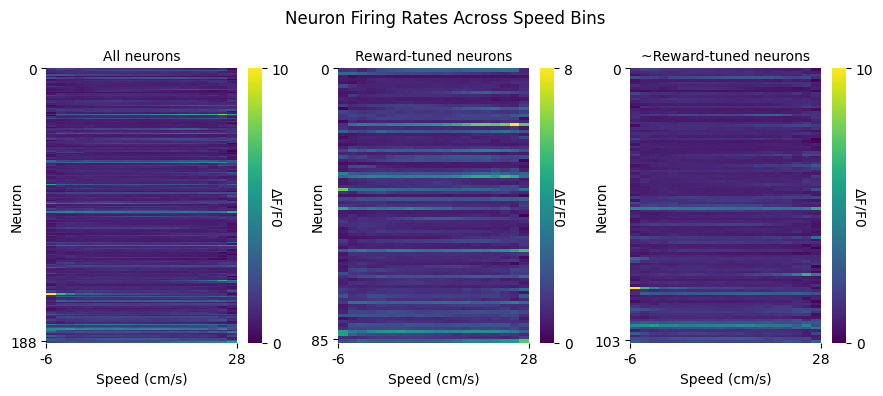

In [225]:
# Plot distribution of firing rates for different speeds 
if reload_results:

    remaining_neurons = np.where(~np.isin(neurons_considered, neurons_considered[all_significant_neurons_reward]))[0]

    # Sort neurons according to max firing rate for each neuron
    # preferred_bins = np.nanargmax(speed_firing_rate, axis=1)  # shape: (num_neurons,)
    # sorted_indices = np.argsort(preferred_bins)
    # sorted_speed_firing_rate = speed_firing_rate[sorted_indices, :]

    bin_centers = (binned_speed[:-1] + binned_speed[1:]) / 2
    xtick_idx = [0, len(bin_centers)]
    xtick_vals = np.round([bin_centers[0], bin_centers[-1]]).astype(int)

    fig, ax = plt.subplots(1, 3, figsize=(9,4), sharex=True)
    ax = ax.ravel()

    # All neurons
    hm1 = sns.heatmap(speed_firing_rate, cmap='viridis', xticklabels=np.round(bin_centers, 2), \
                yticklabels=False, ax=ax[0], cbar=True)
    ax[0].set_yticks([0, num_neurons_considered - 1])  
    ax[0].set_yticklabels([0, num_neurons_considered])  
    ax[0].set_title('All neurons', fontsize=10)

    cbar = hm1.collections[0].colorbar
    vmax = np.nanmax(speed_firing_rate)
    vmin = np.nanmin(speed_firing_rate)
    cbar.set_ticks([vmin, vmax])
    cbar.set_ticklabels([str(int(vmin)), str(int(vmax))])
    cbar.set_label('$\Delta$F/F0', labelpad=-5)
    cbar.ax.yaxis.label.set_rotation(270)

    # Reward-tuned neurons
    hm2 = sns.heatmap(speed_firing_rate[all_significant_neurons_reward], cmap='viridis', xticklabels=np.round(bin_centers, 2), \
                yticklabels=False, ax=ax[1], cbar=True)
    ax[1].set_yticks([0, len(all_significant_neurons_reward) - 1])  
    ax[1].set_yticklabels([0, len(all_significant_neurons_reward)])  
    ax[1].set_title('Reward-tuned neurons', fontsize=10)
        
    cbar = hm2.collections[0].colorbar
    vmax = np.nanmax(speed_firing_rate[all_significant_neurons_reward])
    vmin = np.nanmin(speed_firing_rate[all_significant_neurons_reward])
    cbar.set_ticks([vmin, vmax])
    cbar.set_ticklabels([str(int(vmin)), str(int(vmax))])
    cbar.set_label('$\Delta$F/F0', labelpad=-5)
    cbar.ax.yaxis.label.set_rotation(270)

    # Remaining neurons
    hm3 = sns.heatmap(speed_firing_rate[remaining_neurons], cmap='viridis', xticklabels=np.round(bin_centers, 2), \
                yticklabels=False, ax=ax[2], cbar=True)
    ax[2].set_yticks([0, len(remaining_neurons) - 1])  
    ax[2].set_yticklabels([0, len(remaining_neurons)])  
    ax[2].set_title('~Reward-tuned neurons', fontsize=10)
    
    cbar = hm3.collections[0].colorbar
    vmax = np.nanmax(speed_firing_rate[remaining_neurons])
    vmin = np.nanmin(speed_firing_rate[remaining_neurons])
    cbar.set_ticks([vmin, vmax])
    cbar.set_ticklabels([str(int(vmin)), str(int(vmax))])
    cbar.set_label('$\Delta$F/F0', labelpad=-5)
    cbar.ax.yaxis.label.set_rotation(270)

    for i in range(3):
        ax[i].set_xticks(xtick_idx)
        ax[i].set_xticklabels(xtick_vals)
        ax[i].set_ylabel('Neuron', labelpad=-10)
        ax[i].set_xlabel('Speed (cm/s)')
        ax[i].tick_params(axis='x', labelrotation=0)
    
    fig.suptitle('Neuron Firing Rates Across Speed Bins')
    plt.tight_layout()
    output_path = os.path.join(save_path, 'Speed')
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    plt.savefig(os.path.join(output_path, 'speed_firingRate_distribution.png'))
    plt.show()


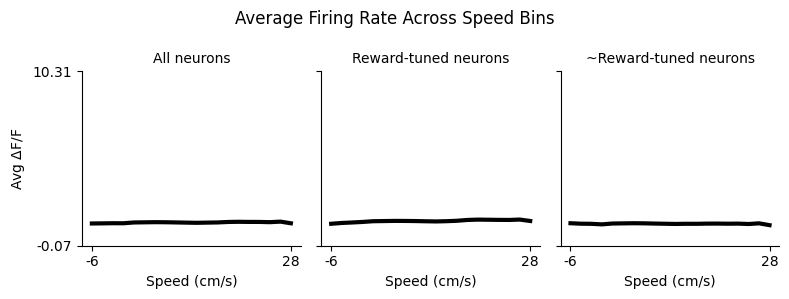

In [226]:
# Get the mean firing rate across speed bins
if reload_results:

    all_means = [speed_firing_rate, speed_firing_rate[all_significant_neurons_reward], speed_firing_rate[remaining_neurons]]
    global_min = np.nanmin(speed_firing_rate)
    global_max = np.nanmax(speed_firing_rate)

    bin_centers = (binned_speed[:-1] + binned_speed[1:]) / 2

    fig, ax = plt.subplots(1, 3, figsize=(8, 3), sharex=False, sharey=True)
    ax = ax.ravel()

    for i in range(3): 
        data_to_plot = np.mean(all_means[i], axis=0)
        valid_bins = ~np.isnan(data_to_plot)
        valid_idx = np.where(valid_bins)[0]

        if len(valid_idx) == 0:
            xtick_idx = []
            xtick_vals = []
        else:
            xtick_idx = [valid_idx[0], valid_idx[-1]]
            xtick_vals = np.round(bin_centers[xtick_idx]).astype(int)

        ax[i].plot(bin_centers[valid_bins], data_to_plot[valid_bins], color='k', linewidth=3)

        ax[i].set_xticks(bin_centers[xtick_idx])  # Use actual bin center values for positioning
        ax[i].set_xticklabels(xtick_vals)
        ax[i].set_ylim(global_min, global_max)
        ax[i].set_yticks([global_min, global_max])
        ax[i].set_yticklabels(np.round([global_min, global_max], 2))

        ax[i].set_xlabel('Speed (cm/s)')
        ax[i].set_title(conditions[i])
        if i == 0:
            ax[i].set_ylabel('Avg $\Delta$F/F')

        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)

    ax[0].set_title('All neurons', fontsize=10)
    ax[1].set_title('Reward-tuned neurons', fontsize=10)
    ax[2].set_title('~Reward-tuned neurons', fontsize=10)
    fig.suptitle('Average Firing Rate Across Speed Bins')
    plt.tight_layout()

    output_path = os.path.join(save_path, 'Speed')
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    plt.savefig(os.path.join(output_path, 'speed_AvgFiringRate.png'))
    plt.show()

In [ ]:
# Look at the speed-related activity profile around different landmarks
if reload_results:

    conditions = ['rewarded', 'lick & miss', 'miss', 'non-goal', 'test']
    ids = [1,2,8,3,4]

    landmark_idx = {}
    for id in ids:
        if id == 1:
            landmark_idx[id] = rewarded_landmarks
        elif id == 2:
            landmark_idx[id] = np.array([i for i in range(num_lms) if i in session['goals_idx'] and i not in rewarded_landmarks
                                        and np.any((lick_idx >= lm_entry_idx[i]) & (lick_idx <= lm_exit_idx[i]))])
        elif id == 3:
            landmark_idx[id] = session['non_goals_idx']
        elif id == 4:
            landmark_idx[id] = session['test_idx']
        elif id == 8:
            landmark_idx[id] = np.array([i for i in range(num_lms) if i in session['goals_idx'] and i not in rewarded_landmarks
                                        and not np.any((lick_idx >= lm_entry_idx[i]) & (lick_idx <= lm_exit_idx[i]))])

    assert len(landmark_idx[1]) + len(landmark_idx[2]) + len(landmark_idx[8]) == len(session['goals_idx']), 'Some landmarks have not been considered.'


In [228]:
# Extract the activity within each landmark, binned by speed, for different groups of neurons
if reload_results:

    selected_neurons = [neurons_considered, neurons_considered[all_significant_neurons_reward], neurons_considered[remaining_neurons]]

    all_lm_speed_firing_rate = [[] for s in range(3)]
    all_average_lm_speed_firing_rate = [[] for s in range(3)]

    for s in range(3):
        lm_speed_firing_rate = {id: {} for id in ids}
        average_lm_speed_firing_rate = {id: {} for id in ids}

        for id in ids:
            fr_matrix = np.full((len(selected_neurons[s]), len(landmark_idx[id]), len(binned_speed) - 1), np.nan)
            
            for i, lm in enumerate(landmark_idx[id]):
                landmark_speed = speed[lm_entry_idx[lm] : lm_exit_idx[lm]]

                for n, neuron in enumerate(selected_neurons[s]):
                    fr_matrix[n, i, :], _, _ = binned_statistic(landmark_speed, DF_F[neuron, lm_entry_idx[lm] : lm_exit_idx[lm]], \
                                                                        statistic='mean', bins=binned_speed)      
            lm_speed_firing_rate[id] = fr_matrix

            # Calculate the average activity 
            average_lm_speed_firing_rate[id] = np.nanmean(lm_speed_firing_rate[id], axis=1)

        all_lm_speed_firing_rate[s] = lm_speed_firing_rate
        all_average_lm_speed_firing_rate[s] = average_lm_speed_firing_rate

    results_speed['all_lm_speed_firing_rate'] = all_lm_speed_firing_rate
    results_speed['all_average_lm_speed_firing_rate'] = all_average_lm_speed_firing_rate

/var/folders/hb/19x78jb503d4_x8gkyw7xdz00000gn/T/ipykernel_10605/98141392.py:25: RuntimeWarning:

Mean of empty slice



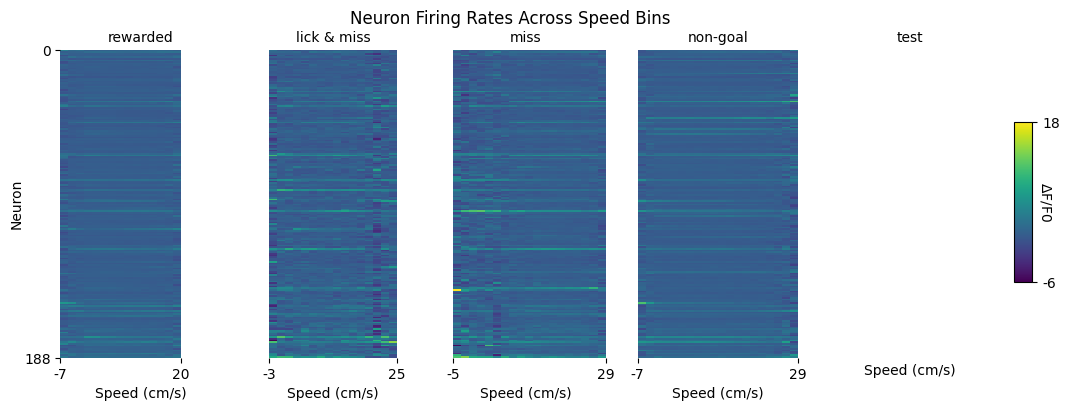

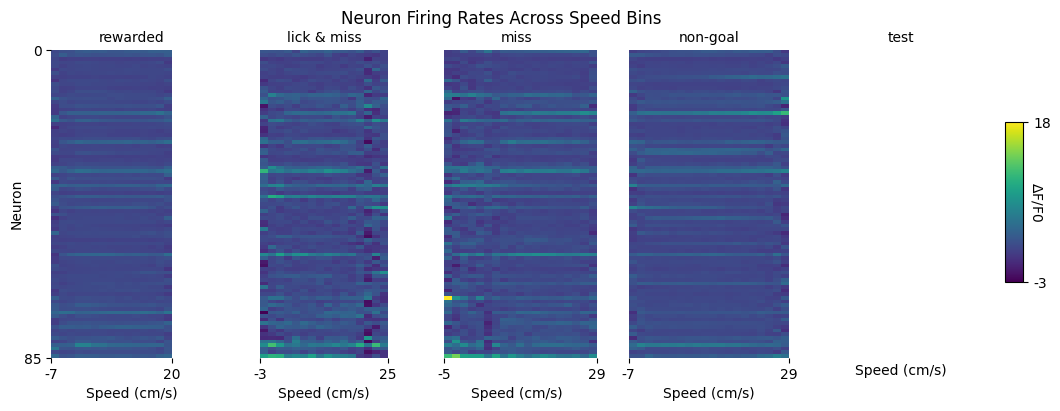

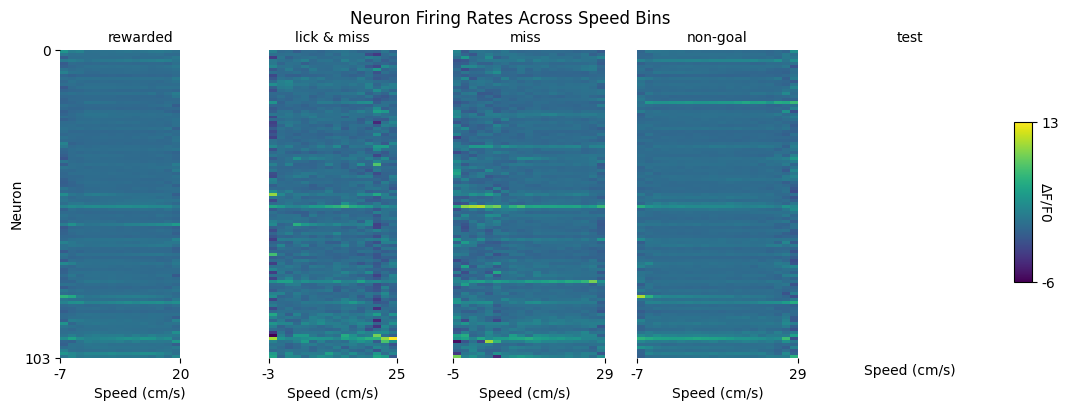

In [229]:
# Plot the distribution of firing rates for different speeds according to landmark ID for reward-tuned neurons
if reload_results:

    for s in range(3):
        
        all_data = np.array([all_average_lm_speed_firing_rate[s][id] for id in ids])
        vmin = np.nanmin(all_data)
        vmax = np.nanmax(all_data)

        bin_centers = (binned_speed[:-1] + binned_speed[1:]) / 2

        fig, ax = plt.subplots(1, len(conditions), figsize=(12, 4), sharex=False, sharey=False)
        ax = ax.ravel()

        for i, id in enumerate(ids): 
            # Get indices of bins (columns) that contain at least one non-NaN
            valid_bins = ~np.all(np.isnan(all_average_lm_speed_firing_rate[s][id]), axis=0)
            valid_idx = np.where(valid_bins)[0]

            if len(valid_idx) == 0:
                xtick_idx = []
                xtick_vals = []
            else:
                xtick_idx = [valid_idx[0], valid_idx[-1]+1]
                # print(binned_speed[xtick_idx])
                xtick_vals = np.round(binned_speed[xtick_idx]).astype(int)

            hm = sns.heatmap(all_average_lm_speed_firing_rate[s][id], cmap='viridis', xticklabels=False, yticklabels=False, \
                            ax=ax[i], cbar=False, vmin=vmin, vmax=vmax)

            ax[i].set_xticks(xtick_idx)
            ax[i].set_xticklabels(xtick_vals)
            ax[i].set_xlabel('Speed (cm/s)')
            ax[i].tick_params(axis='x', labelrotation=0)
            ax[i].set_title(f'{conditions[i]}', fontsize=10)

        ax[0].set_ylabel('Neuron', labelpad=0)
        ax[0].set_yticks([0, all_average_lm_speed_firing_rate[s][1].shape[0]])
        ax[0].set_yticklabels([0, all_average_lm_speed_firing_rate[s][1].shape[0]])

        # Shared colorbar
        cbar_ax = fig.add_axes([0.92, 0.3, 0.015, 0.4])
        cbar = fig.colorbar(hm.collections[0], cax=cbar_ax)
        cbar.set_ticks([vmin, vmax])
        cbar.set_ticklabels([str(int(vmin)), str(int(vmax))])
        cbar.set_label('$\Delta$F/F0', labelpad=-5)
        cbar.ax.yaxis.label.set_rotation(270)

        fig.suptitle('Neuron Firing Rates Across Speed Bins')

        output_path = os.path.join(save_path, 'Speed')
        if not os.path.exists(output_path):
            os.makedirs(output_path)
        plt.savefig(os.path.join(output_path, f'speed_firingRate_distribution_landmarks_Neurons{s}.png'))
        plt.show()


/var/folders/hb/19x78jb503d4_x8gkyw7xdz00000gn/T/ipykernel_10605/1358433980.py:6: RuntimeWarning:

Mean of empty slice

/var/folders/hb/19x78jb503d4_x8gkyw7xdz00000gn/T/ipykernel_10605/1358433980.py:14: RuntimeWarning:

Mean of empty slice

/var/folders/hb/19x78jb503d4_x8gkyw7xdz00000gn/T/ipykernel_10605/1358433980.py:14: RuntimeWarning:

Mean of empty slice

/var/folders/hb/19x78jb503d4_x8gkyw7xdz00000gn/T/ipykernel_10605/1358433980.py:14: RuntimeWarning:

Mean of empty slice

/var/folders/hb/19x78jb503d4_x8gkyw7xdz00000gn/T/ipykernel_10605/1358433980.py:14: RuntimeWarning:

Mean of empty slice



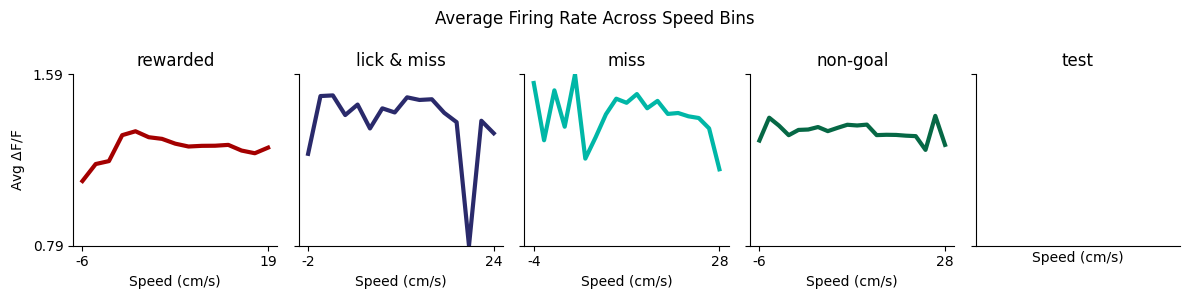

/var/folders/hb/19x78jb503d4_x8gkyw7xdz00000gn/T/ipykernel_10605/1358433980.py:6: RuntimeWarning:

Mean of empty slice

/var/folders/hb/19x78jb503d4_x8gkyw7xdz00000gn/T/ipykernel_10605/1358433980.py:14: RuntimeWarning:

Mean of empty slice

/var/folders/hb/19x78jb503d4_x8gkyw7xdz00000gn/T/ipykernel_10605/1358433980.py:14: RuntimeWarning:

Mean of empty slice

/var/folders/hb/19x78jb503d4_x8gkyw7xdz00000gn/T/ipykernel_10605/1358433980.py:14: RuntimeWarning:

Mean of empty slice

/var/folders/hb/19x78jb503d4_x8gkyw7xdz00000gn/T/ipykernel_10605/1358433980.py:14: RuntimeWarning:

Mean of empty slice



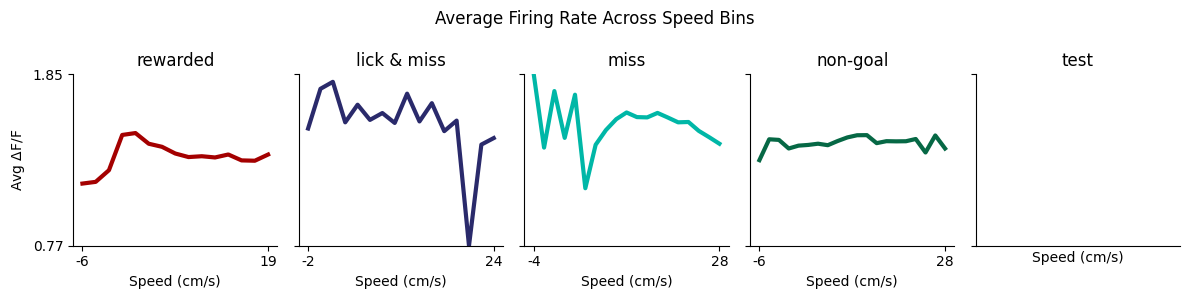

/var/folders/hb/19x78jb503d4_x8gkyw7xdz00000gn/T/ipykernel_10605/1358433980.py:6: RuntimeWarning:

Mean of empty slice

/var/folders/hb/19x78jb503d4_x8gkyw7xdz00000gn/T/ipykernel_10605/1358433980.py:14: RuntimeWarning:

Mean of empty slice

/var/folders/hb/19x78jb503d4_x8gkyw7xdz00000gn/T/ipykernel_10605/1358433980.py:14: RuntimeWarning:

Mean of empty slice

/var/folders/hb/19x78jb503d4_x8gkyw7xdz00000gn/T/ipykernel_10605/1358433980.py:14: RuntimeWarning:

Mean of empty slice

/var/folders/hb/19x78jb503d4_x8gkyw7xdz00000gn/T/ipykernel_10605/1358433980.py:14: RuntimeWarning:

Mean of empty slice



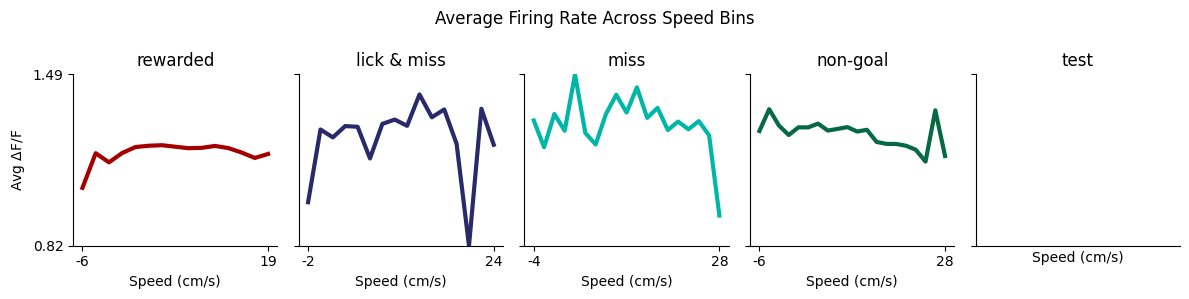

In [230]:
# Plot average firing rate across neurons per speed bin
if reload_results:

    for s in range(3):

        all_means = [np.nanmean(all_average_lm_speed_firing_rate[s][id], axis=0) for id in ids]
        global_min = np.nanmin(all_means)
        global_max = np.nanmax(all_means)

        fig, ax = plt.subplots(1, len(conditions), figsize=(12, 3), sharex=False, sharey=True)
        ax = ax.ravel()

        for i, id in enumerate(ids): 
            data_to_plot = np.nanmean(all_average_lm_speed_firing_rate[s][id], axis=0)
            valid_bins = ~np.isnan(data_to_plot)
            valid_idx = np.where(valid_bins)[0]

            if len(valid_idx) == 0:
                xtick_idx = []
                xtick_vals = []
            else:
                xtick_idx = [valid_idx[0], valid_idx[-1]]
                xtick_vals = np.round(bin_centers[xtick_idx]).astype(int)

            ax[i].plot(bin_centers[valid_bins], data_to_plot[valid_bins], color=hfs_palette[id-1], linewidth=3)

            ax[i].set_xticks(bin_centers[xtick_idx])  # Use actual bin center values for positioning
            ax[i].set_xticklabels(xtick_vals)
            ax[i].set_ylim(global_min, global_max)
            ax[i].set_yticks([global_min, global_max])
            ax[i].set_yticklabels(np.round([global_min, global_max], 2))

            ax[i].set_xlabel('Speed (cm/s)')
            ax[i].set_title(conditions[i])
            if i == 0:
                ax[i].set_ylabel('Avg $\Delta$F/F')

            ax[i].spines['top'].set_visible(False)
            ax[i].spines['right'].set_visible(False)

        fig.suptitle('Average Firing Rate Across Speed Bins')
        plt.tight_layout()

        output_path = os.path.join(save_path, 'Speed')
        if not os.path.exists(output_path):
            os.makedirs(output_path)
        plt.savefig(os.path.join(output_path, f'speed_AvgFiringRate_landmarks_Neurons{s}.png'))
        plt.show()

In [231]:
# Save results 
if reload_results:
    np.savez(save_filename, **{k: np.array(v, dtype=object) for k, v in results_speed.items()})